<a href="https://colab.research.google.com/github/avladova/Railway-track-deviations/blob/main/Control_Sciences_Railway_track_deviations_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm

import re
import datetime as dt
import seaborn as sns
import plotly.express as px
import missingno as msno
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

import logging
import warnings
import sys
from prophet import Prophet

from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [48]:
url='https://github.com/avladova/Railway-track-deviations/blob/main/fragment%202%20intervals%20(1).xlsx?raw=true'
df=pd.read_excel(url, 
                  dtype={'ВРЕМЯ': datetime, 'ГОД':int, 'МЕСЯЦ':int,'КМ':int, 'М':int, 'ДИСТАНЦИЯ':int, 
                         'КОДОТСТУП':int, 'НОРМА':int, 'СТЕПЕНЬ':int})
print(df.info())
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   КМ           1657 non-null   int64         
 1   М            1657 non-null   int64         
 2   АМПЛИТУДА    1657 non-null   int64         
 3   HOPMA        1657 non-null   int64         
 4   КОДОТСТУП    1657 non-null   int64         
 5   ГОД          1657 non-null   int64         
 6   МЕСЯЦ        1657 non-null   int64         
 7   ДЕНЬ         1657 non-null   int64         
 8   СТЕПЕНЬ      1657 non-null   int64         
 9   ДЛИНА        1657 non-null   int64         
 10  ОТСТУПЛЕНИЕ  1657 non-null   object        
 11  ВРЕМЯ        1657 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 155.5+ KB
None


,КМ,М,АМПЛИТУДА,HOPMA,КОДОТСТУП,ГОД,МЕСЯЦ,ДЕНЬ,СТЕПЕНЬ,ДЛИНА,ОТСТУПЛЕНИЕ,ВРЕМЯ
1285,611,810,14,0,2065,2021,1,30,1,17,Рст,2021-01-30
1009,639,122,16,0,2065,2019,8,10,2,38,Р,2019-08-10
446,650,137,20,0,2065,2018,12,17,1,18,Р,2018-12-17
1522,24,326,10,0,2065,2021,2,22,1,14,Рст,2021-02-22
40,634,971,11,0,2065,2021,2,20,2,20,Р,2021-02-20


In [29]:
resRep = []
for colName in df.columns:
    col = df[colName]
    resRep.append([colName,col.dtype,len(col.unique()),sum(~col.isna()),col.unique()[:8]])
pd.DataFrame(resRep,columns=['Поле','тип','число уникальных','not NaN','пример'])

,Поле,тип,число уникальных,not NaN,пример
0,КМ,int64,40,1657,"[19, 634, 26, 610, 611, 630, 631, 638]"
1,М,int64,685,1657,"[146, 801, 839, 595, 838, 786, 784, 788]"
2,АМПЛИТУДА,int64,36,1657,"[18, 13, 17, 19, 22, 20, 11, 12]"
3,HOPMA,int64,1,1657,[0]
4,КОДОТСТУП,int64,1,1657,[2065]
5,ГОД,int64,4,1657,"[2018, 2020, 2019, 2021]"
6,МЕСЯЦ,int64,12,1657,"[5, 7, 8, 9, 6, 10, 11, 12]"
7,ДЕНЬ,int64,28,1657,"[18, 24, 13, 1, 12, 26, 19, 15]"
8,СТЕПЕНЬ,int64,4,1657,"[2, 1, 3, 4]"
9,ДЛИНА,int64,36,1657,"[33, 14, 26, 23, 22, 16, 13, 15]"


# 3D matrix

In [30]:
df['КОДОТСТУП'] = pd.to_numeric(df['КОДОТСТУП'],errors='coerce',downcast='integer')
df['HOPMA'] = pd.to_numeric(df['HOPMA'],errors='coerce',downcast='integer')

In [31]:
df['ВРЕМЯ'] = df.apply(lambda r: datetime.strptime(f"{r['ГОД']} {r['МЕСЯЦ']} {r['ДЕНЬ']}", '%Y %m %d'), axis=1)
df['ДИСТАНЦИЯ'] = df['КМ']*1000+df['М']
df['АМПЛИТУДА'] = pd.to_numeric(df['АМПЛИТУДА'],errors='coerce',downcast='float')
df['ОТКЛОНЕНИЕ']=df['АМПЛИТУДА']-df['HOPMA']
df['ПЛОЩАДЬ_А']=df['АМПЛИТУДА']*df['ДЛИНА']
df['ПЛОЩАДЬ_О']=df['ОТКЛОНЕНИЕ']*df['ДЛИНА']

In [32]:
miss=df.set_index(['КОДОТСТУП', 'ДИСТАНЦИЯ','ВРЕМЯ']).drop(columns=['МЕСЯЦ','ДЕНЬ','М'])
miss = miss[~miss.index.duplicated()]
cols=['АМПЛИТУДА', 'HOPMA','ДЛИНА', 'ОТКЛОНЕНИЕ','ПЛОЩАДЬ_А', 'ПЛОЩАДЬ_О']
miss.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1656 entries, (2065, 19146, Timestamp('2018-05-18 00:00:00')) to (2065, 639269, Timestamp('2021-02-21 00:00:00'))
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   КМ           1656 non-null   int64  
 1   АМПЛИТУДА    1656 non-null   float32
 2   HOPMA        1656 non-null   int8   
 3   ГОД          1656 non-null   int64  
 4   СТЕПЕНЬ      1656 non-null   int64  
 5   ДЛИНА        1656 non-null   int64  
 6   ОТСТУПЛЕНИЕ  1656 non-null   object 
 7   ОТКЛОНЕНИЕ   1656 non-null   float32
 8   ПЛОЩАДЬ_А    1656 non-null   float64
 9   ПЛОЩАДЬ_О    1656 non-null   float64
dtypes: float32(2), float64(2), int64(4), int8(1), object(1)
memory usage: 163.9+ KB


In [33]:
scaler = MinMaxScaler()
miss[cols] = scaler.fit_transform(miss[cols].to_numpy())
miss.describe()

,КМ,АМПЛИТУДА,HOPMA,ГОД,СТЕПЕНЬ,ДЛИНА,ОТКЛОНЕНИЕ,ПЛОЩАДЬ_А,ПЛОЩАДЬ_О
count,1656.000000,1656.000000,1656.0,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000
mean,509.407005,0.185375,0.0,2019.592391,1.730676,0.565381,0.185375,0.206449,0.206449
std,244.171830,0.108767,0.0,1.197647,0.468901,0.210361,0.108767,0.121208,0.121208
min,19.000000,0.000000,0.0,2018.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,610.000000,0.096154,0.0,2018.000000,1.000000,0.405405,0.096154,0.098599,0.098599
50%,630.000000,0.173077,0.0,2020.000000,2.000000,0.540541,0.173077,0.221849,0.221849
75%,639.000000,0.230769,0.0,2021.000000,2.000000,0.729730,0.230769,0.298039,0.298039
max,650.000000,1.000000,0.0,2021.000000,4.000000,1.000000,1.000000,1.000000,1.000000


# Визуализации

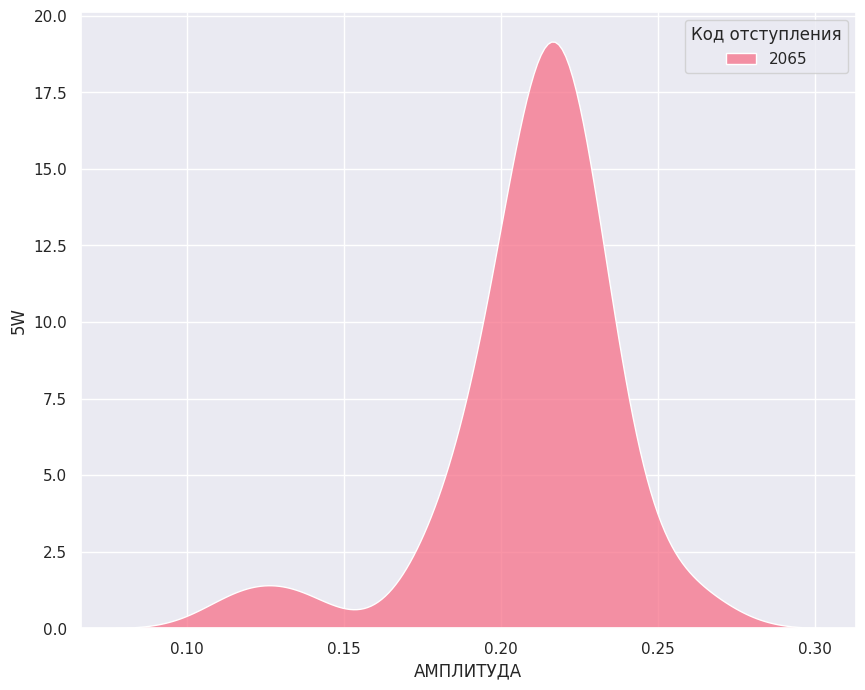

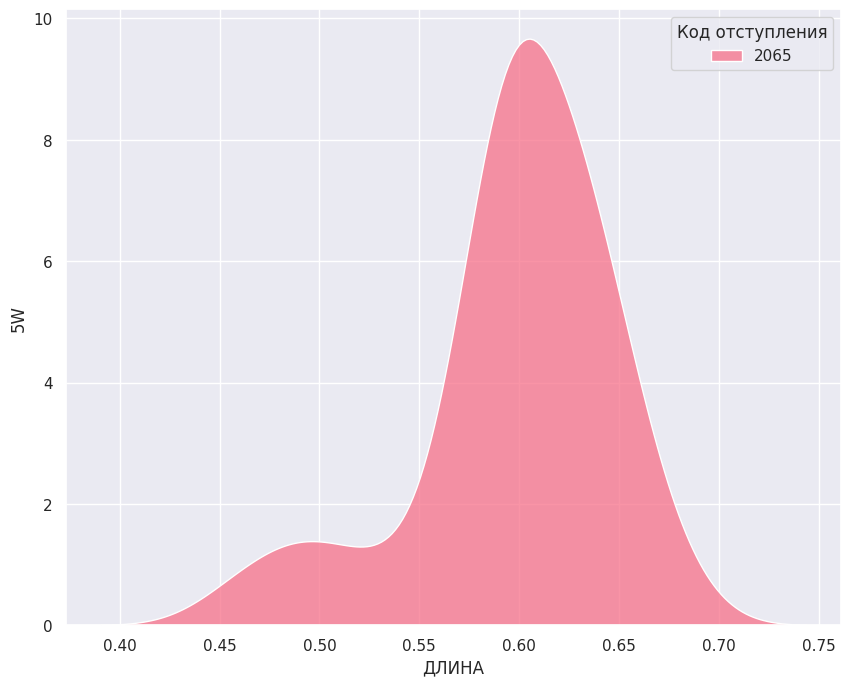

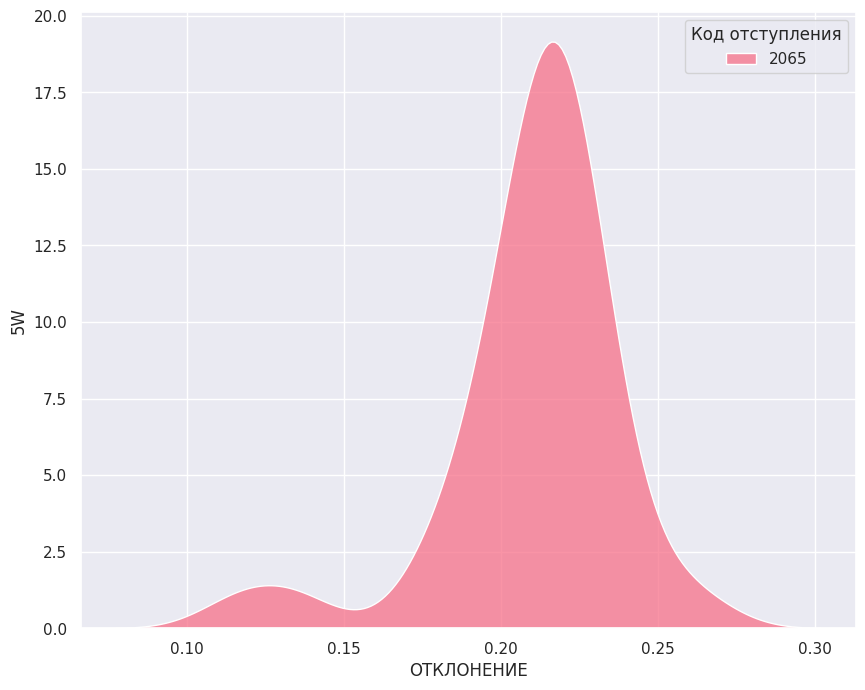

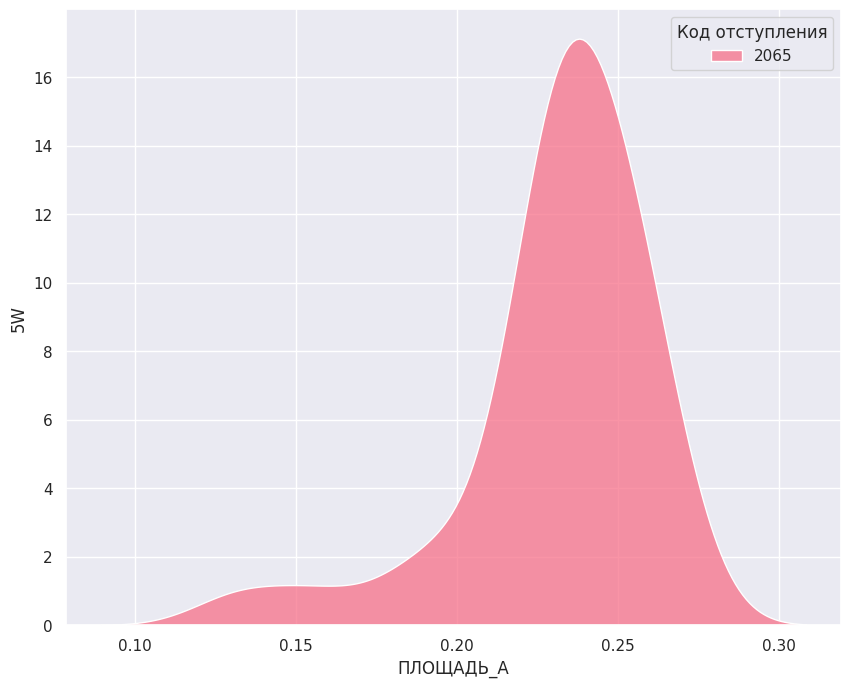

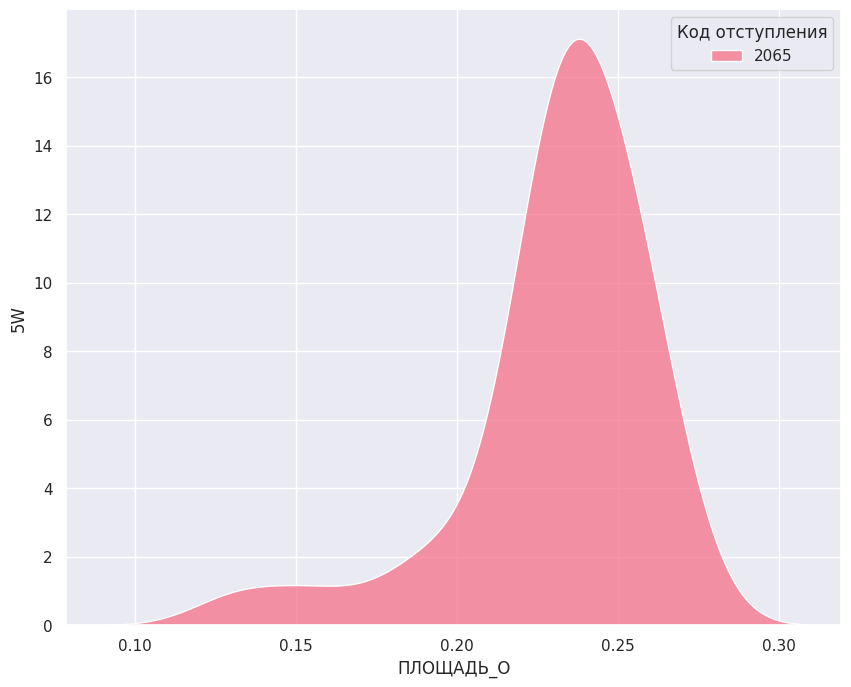

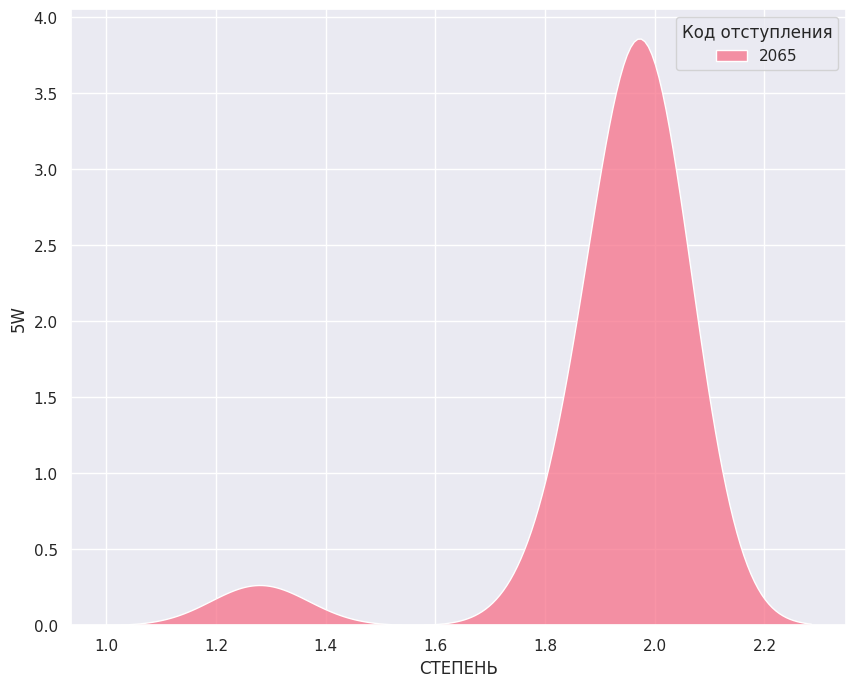

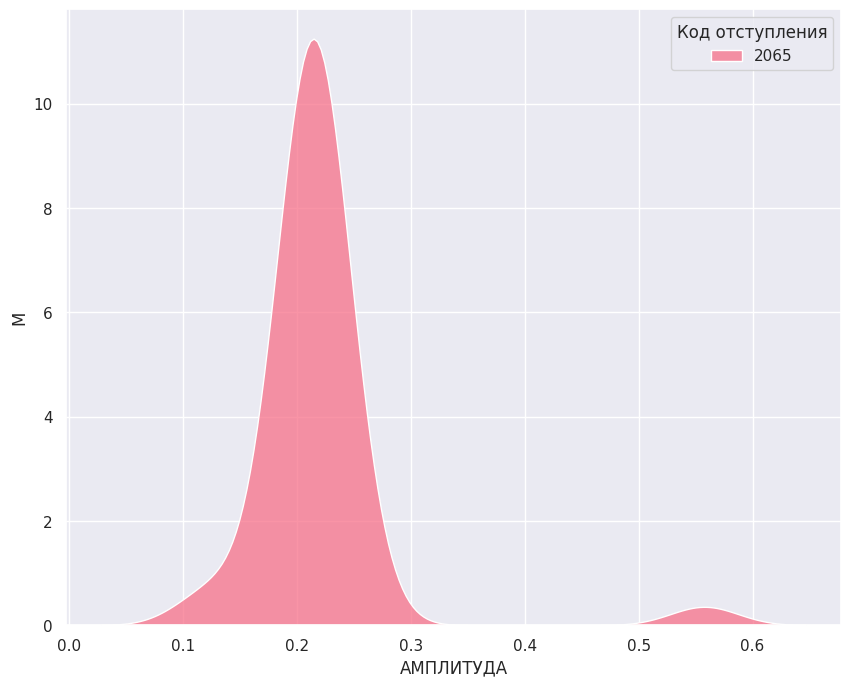

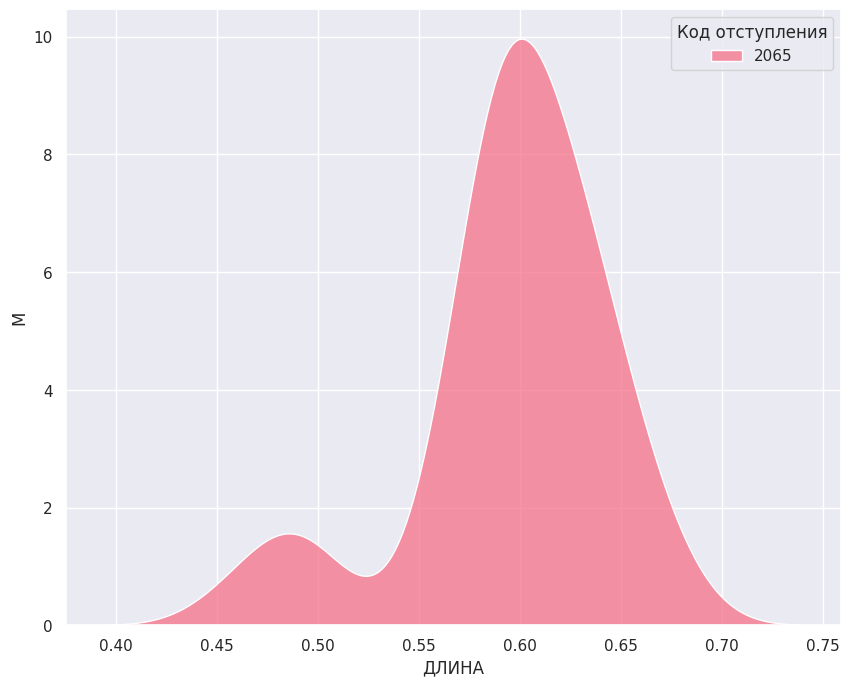

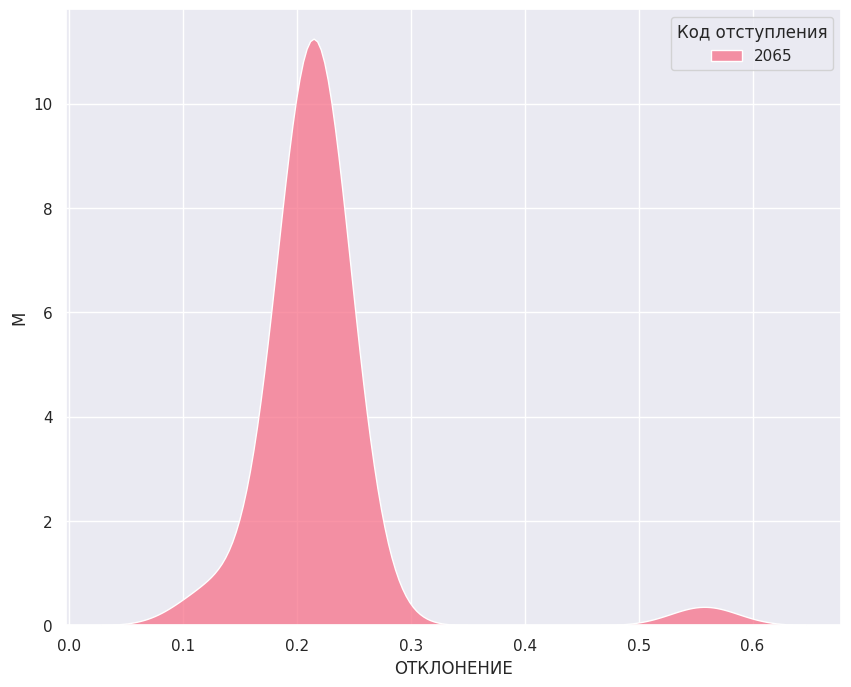

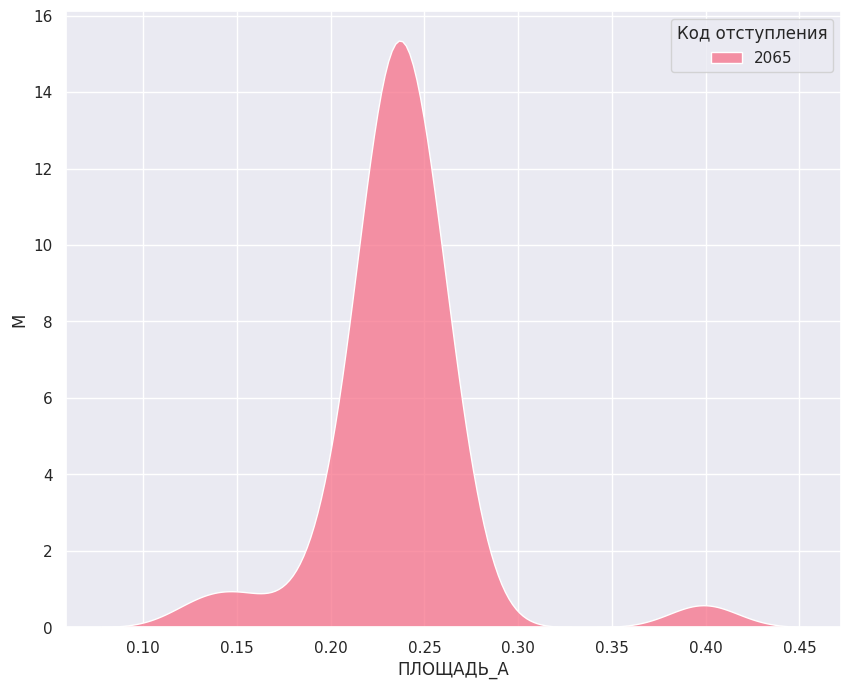

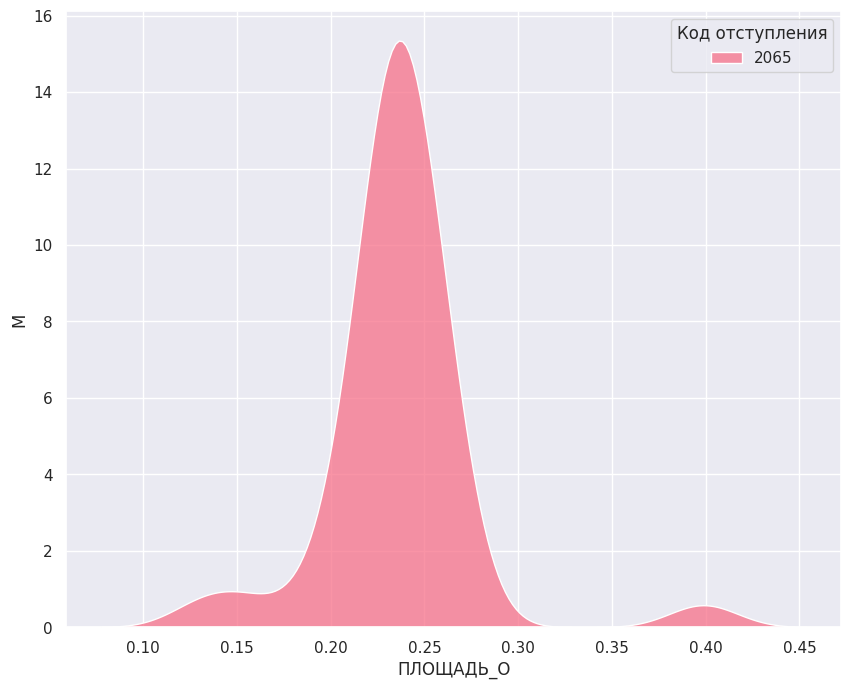

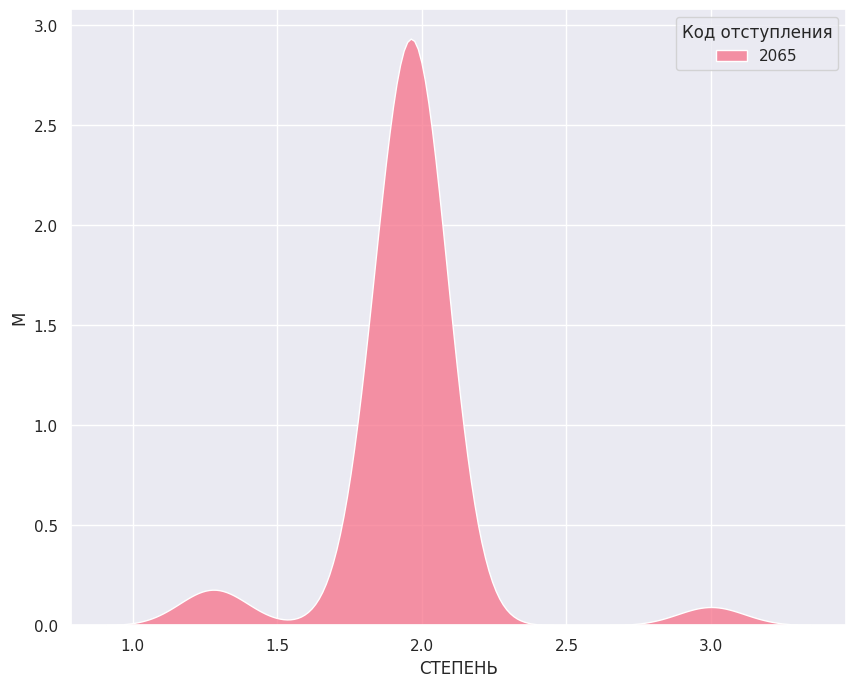

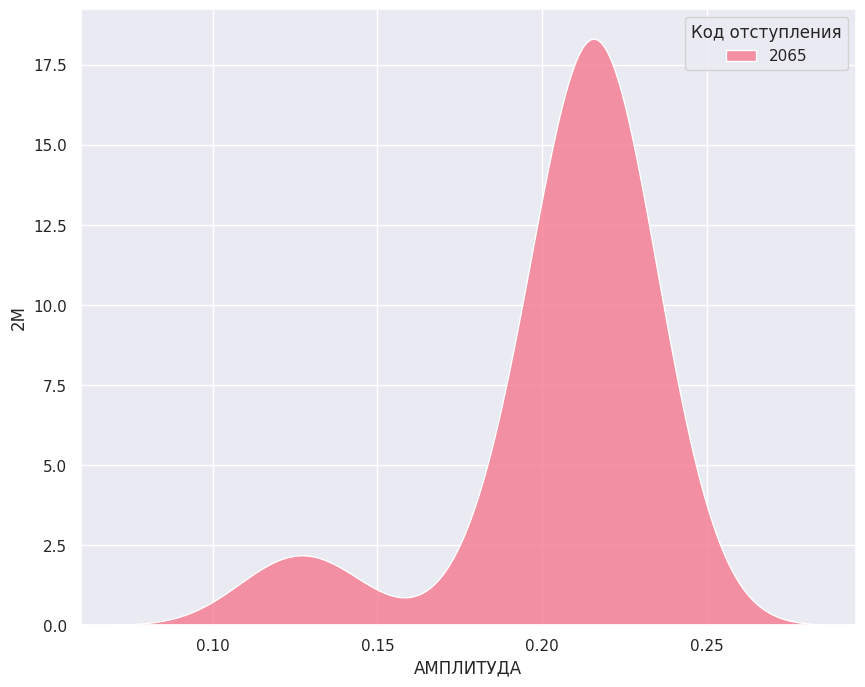

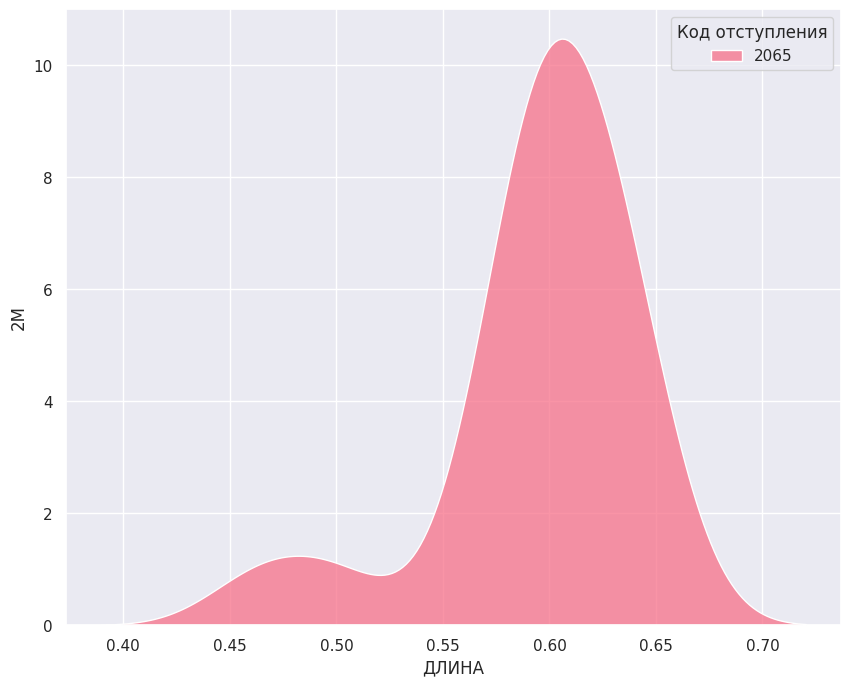

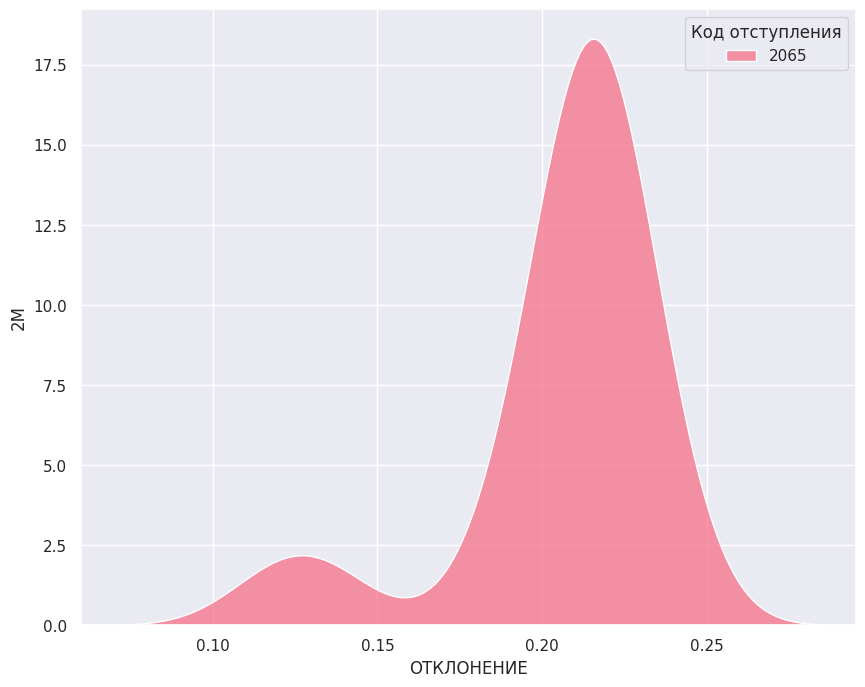

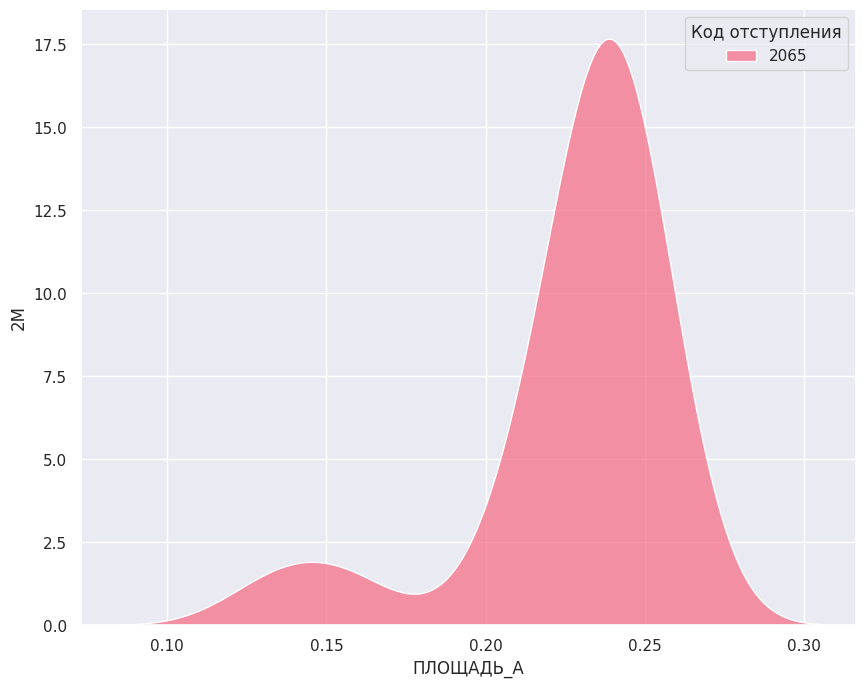

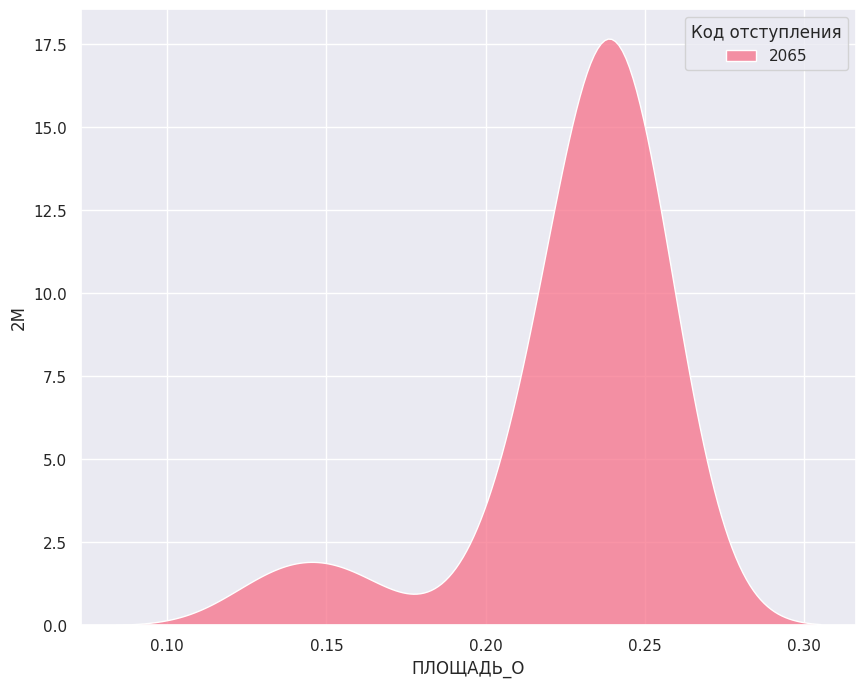

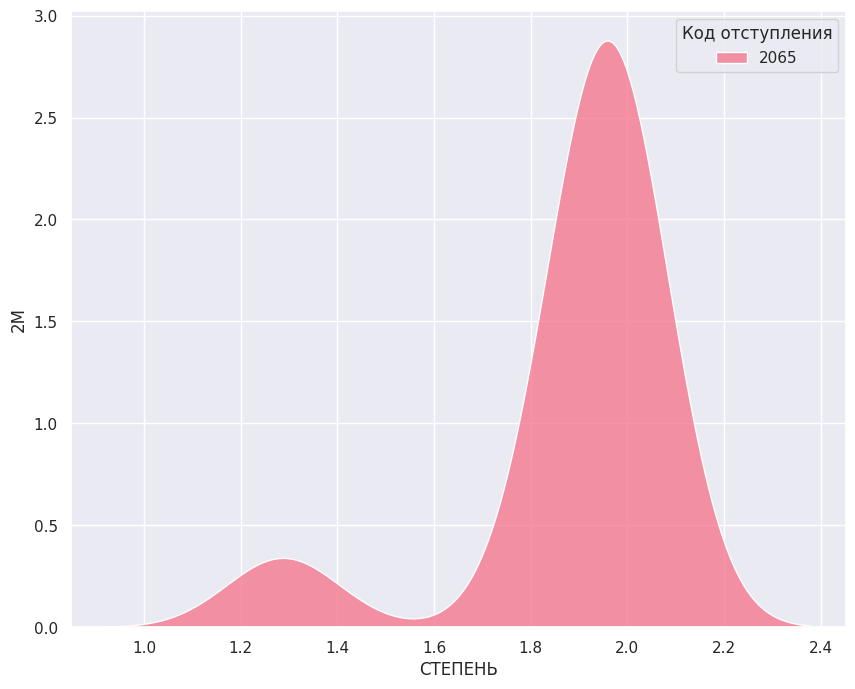

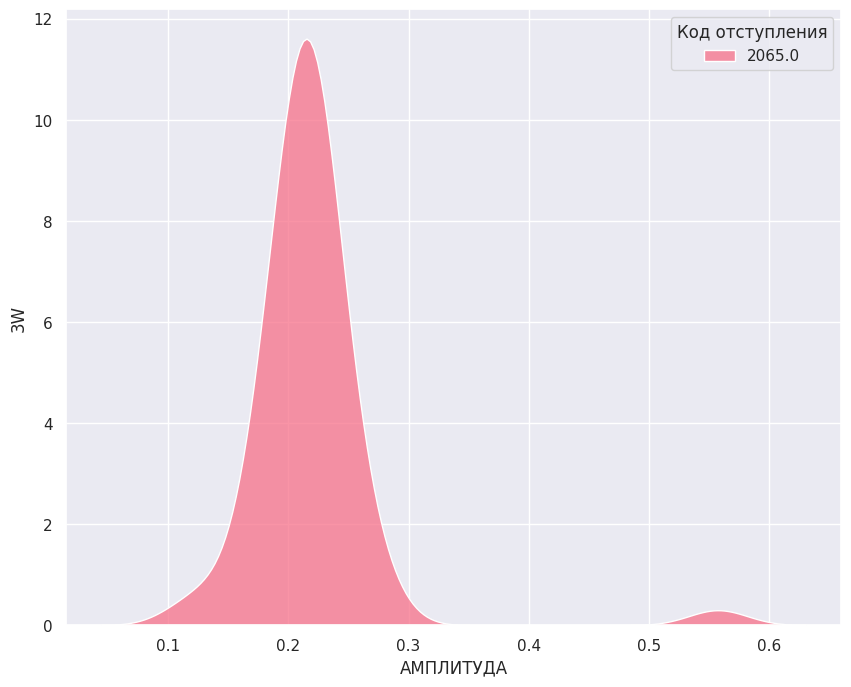

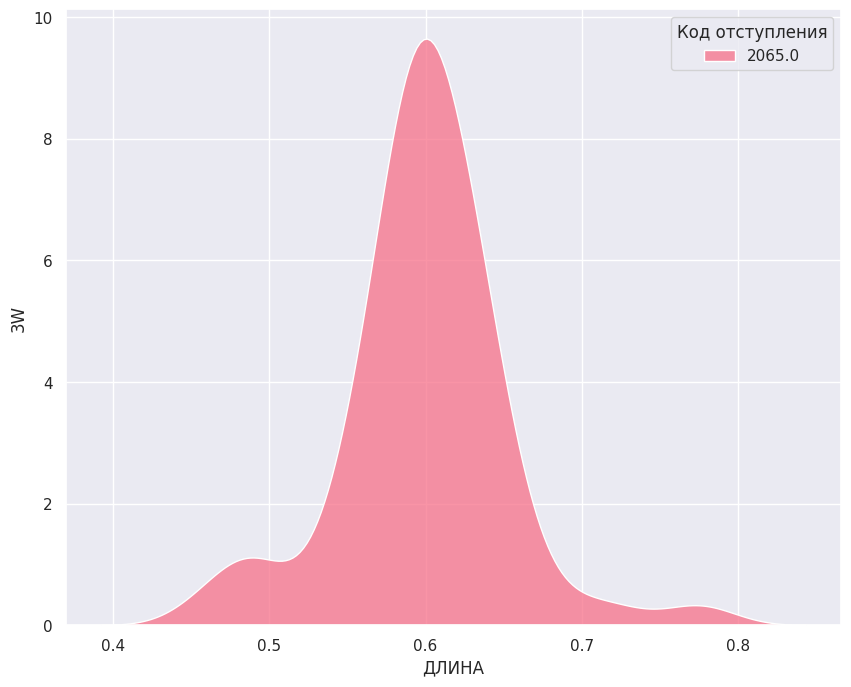

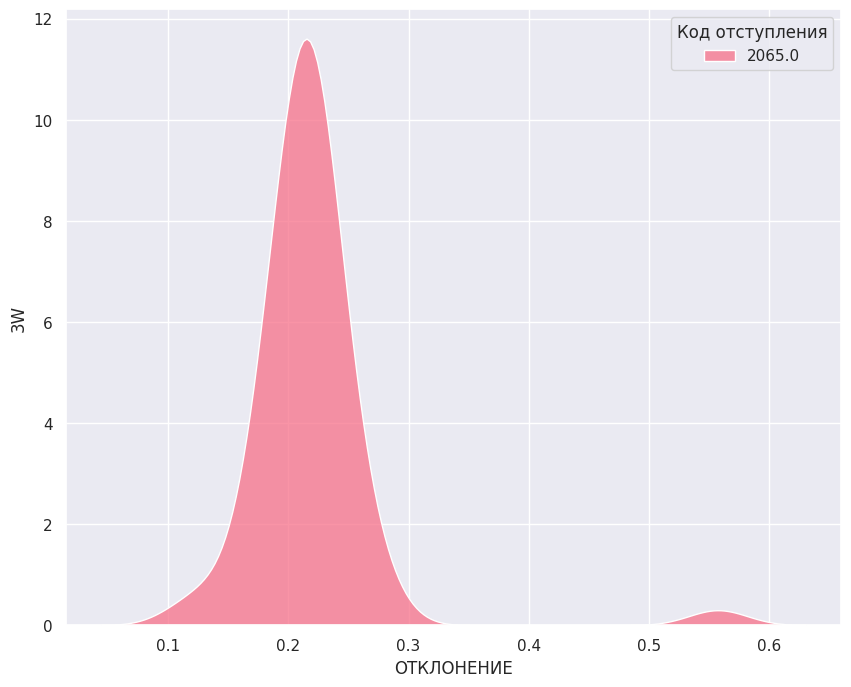

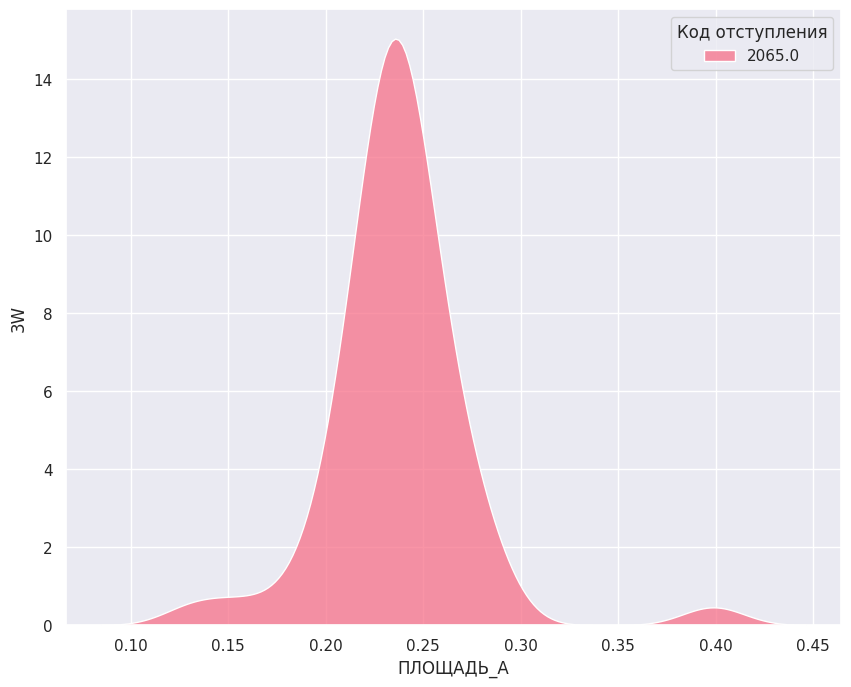

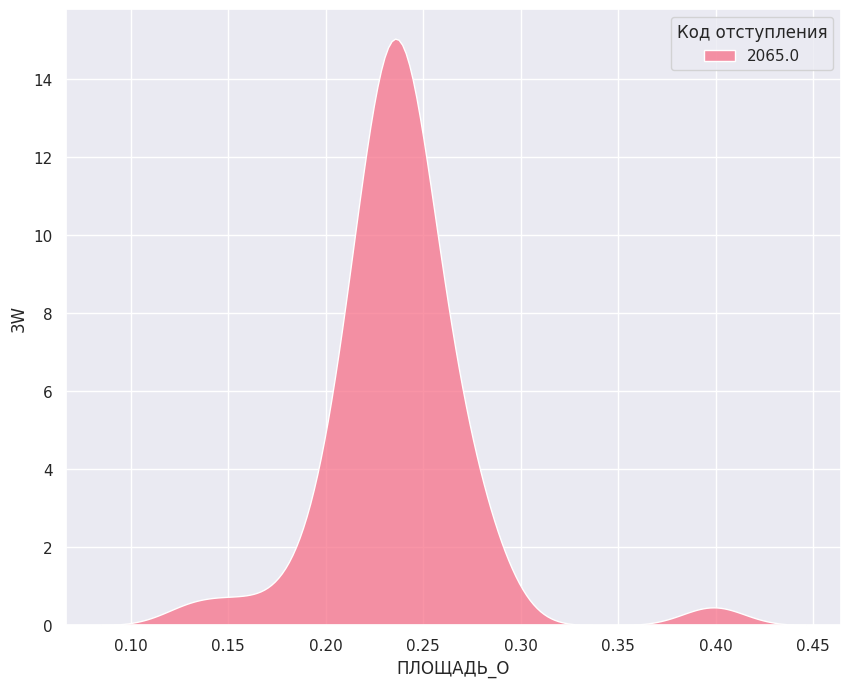

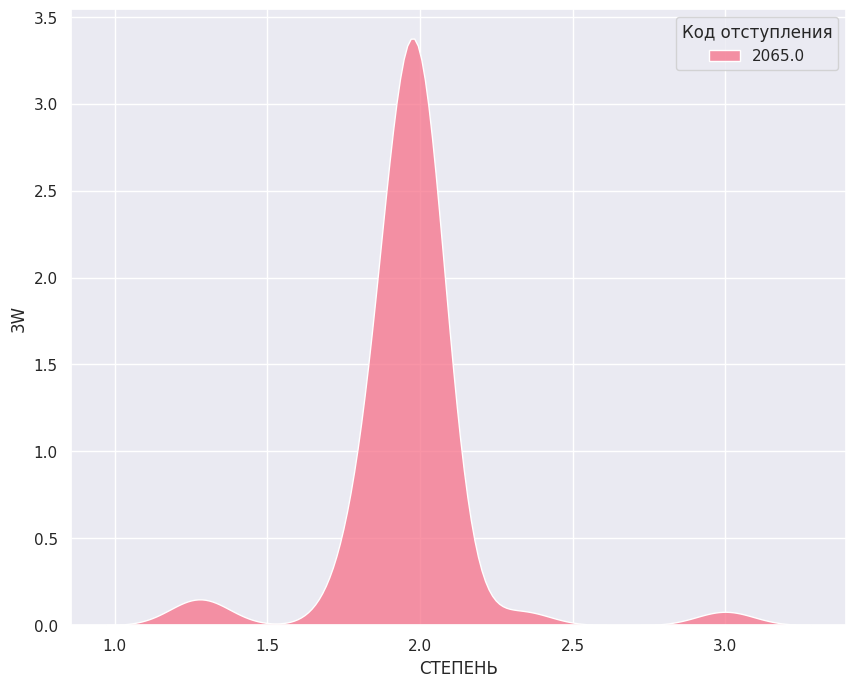

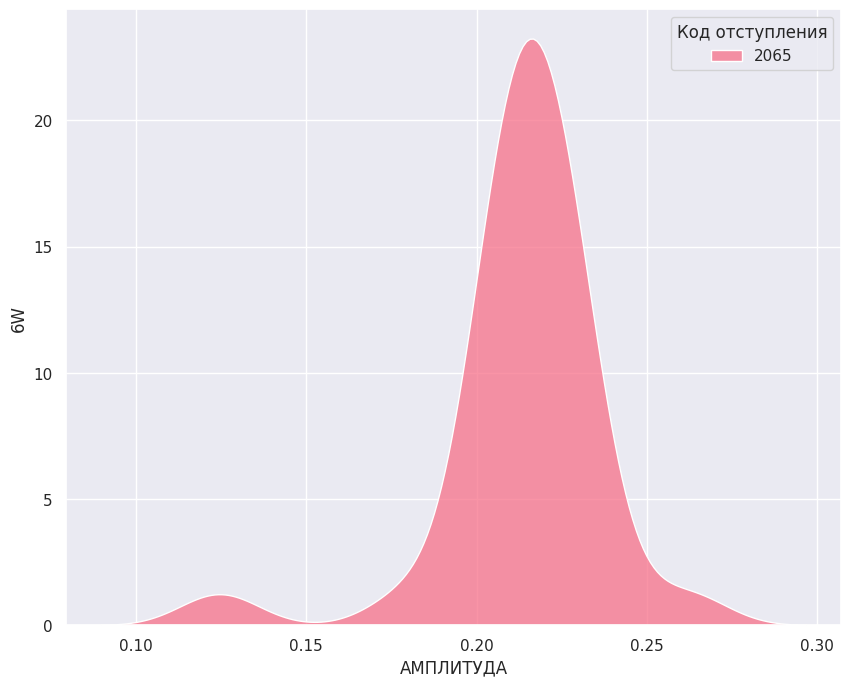

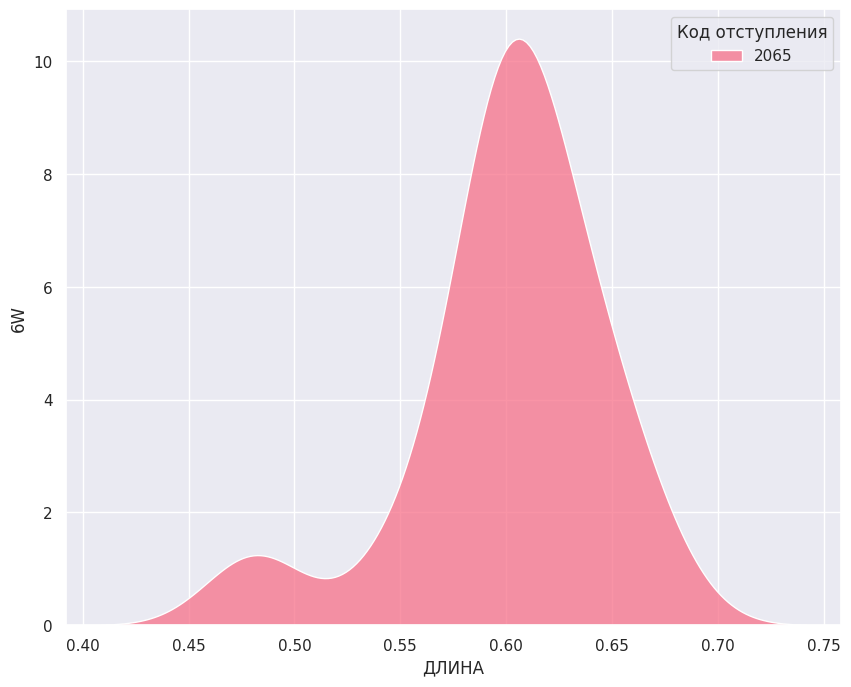

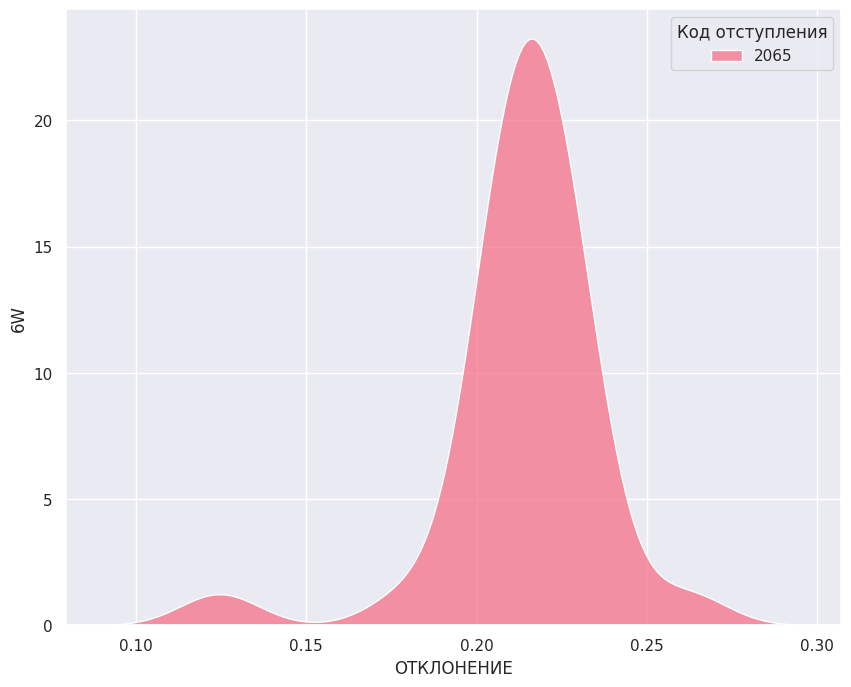

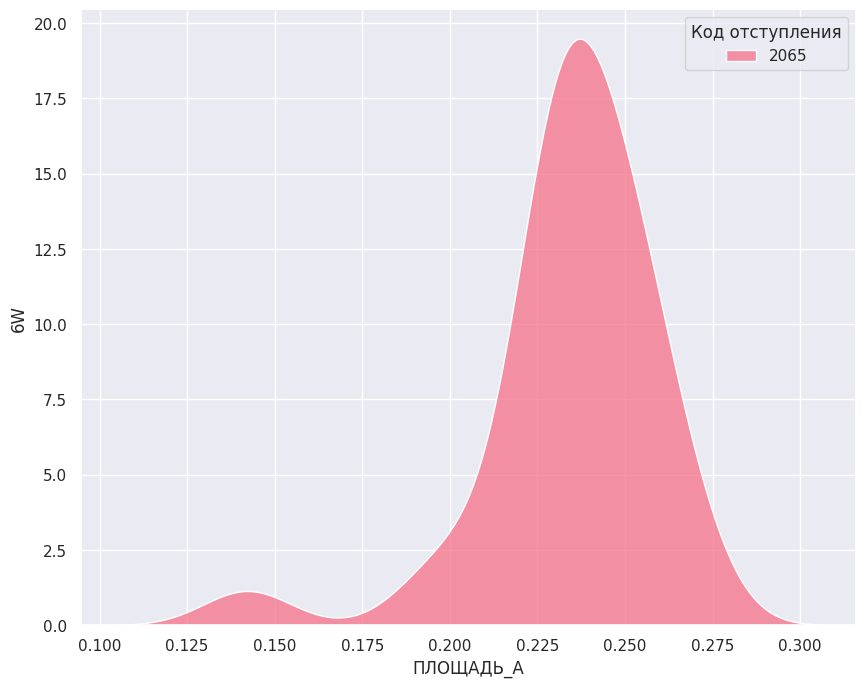

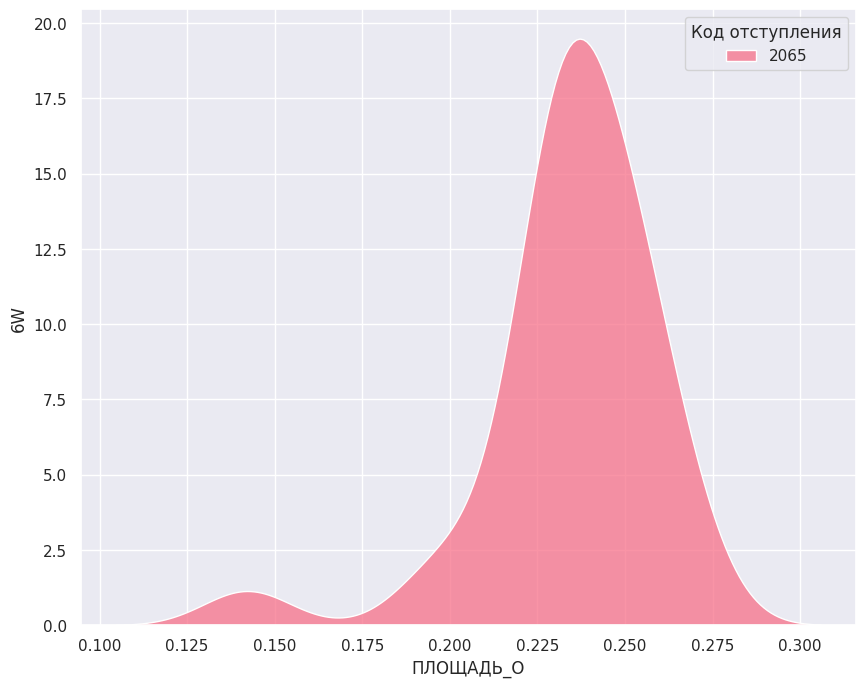

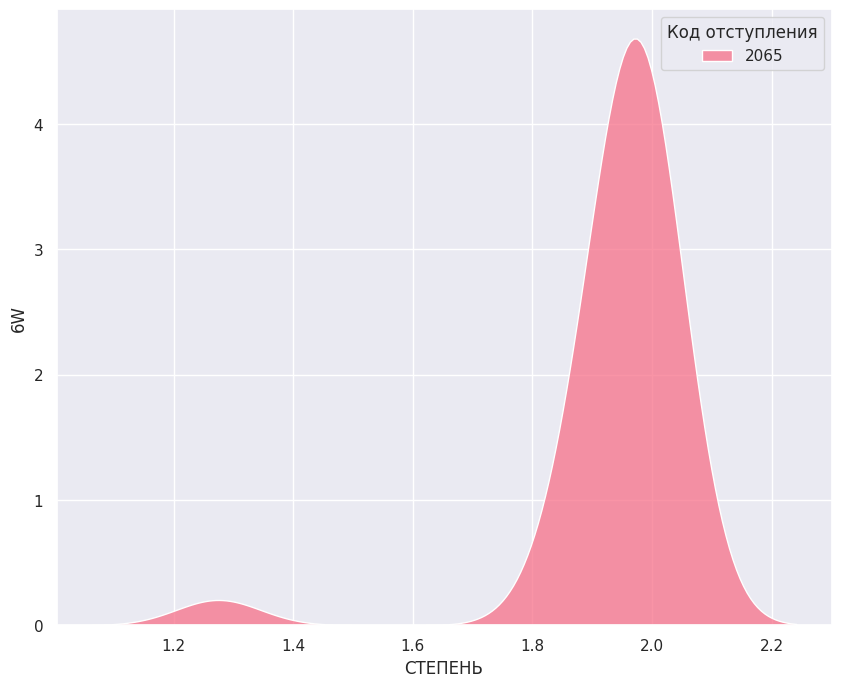

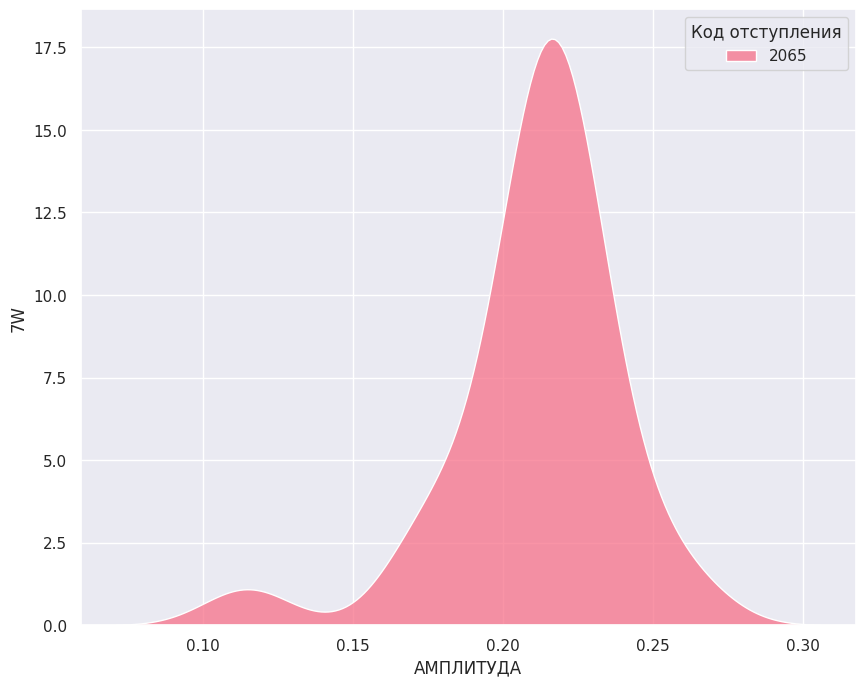

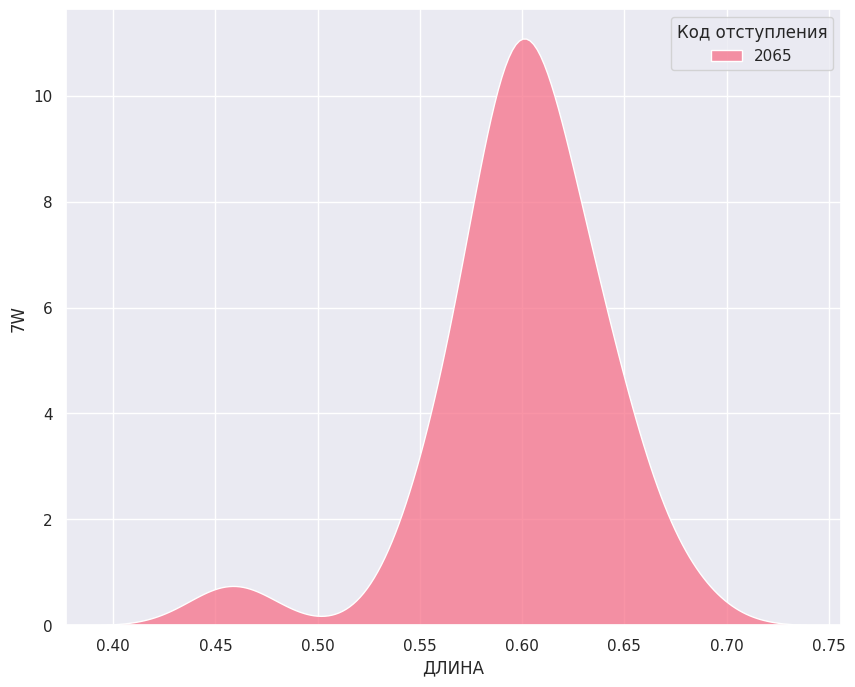

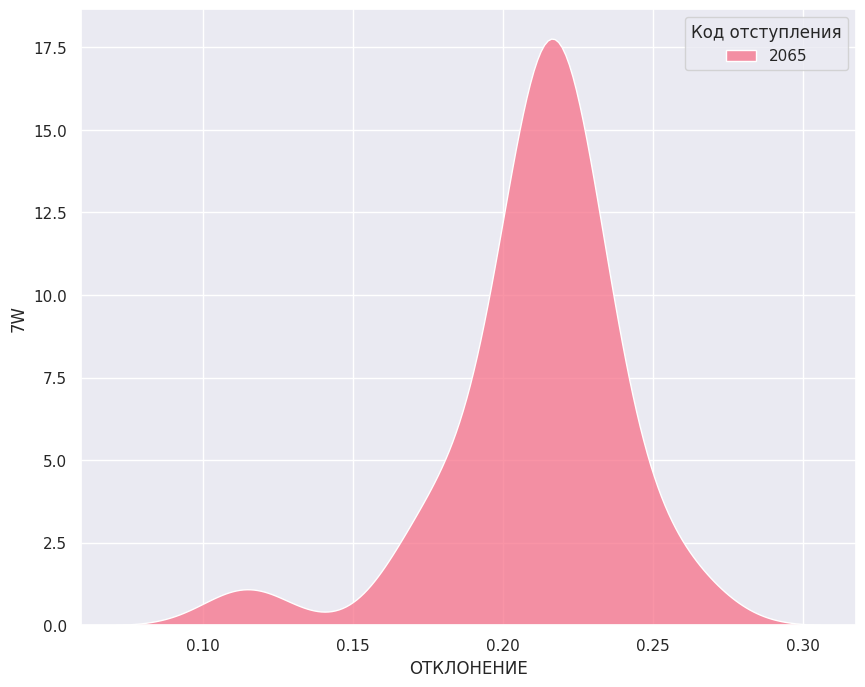

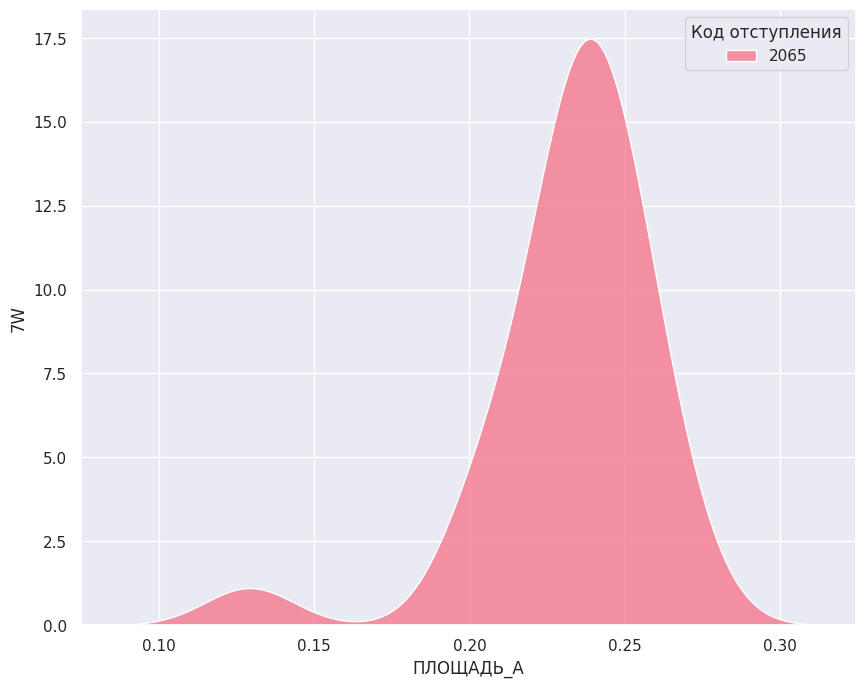

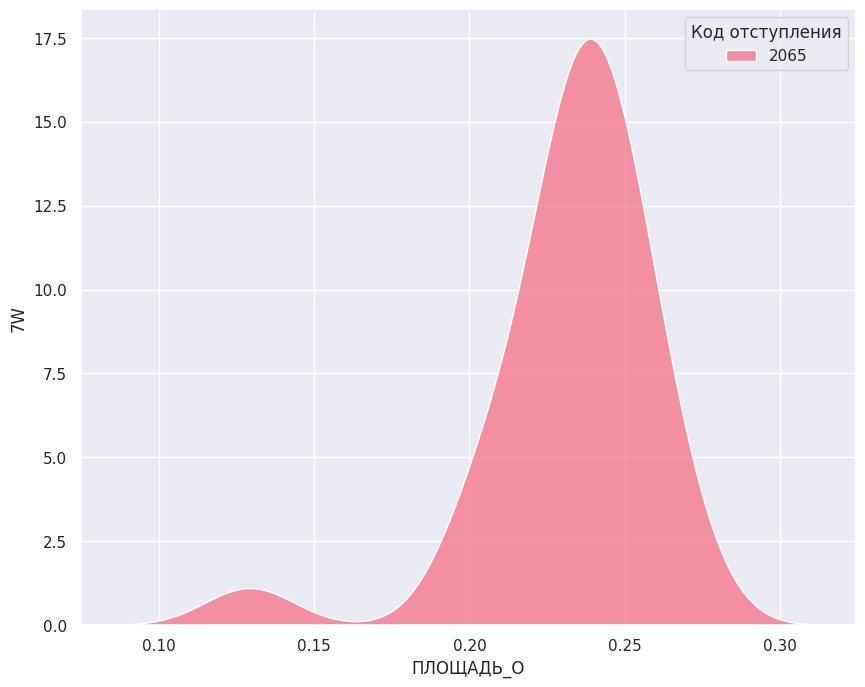

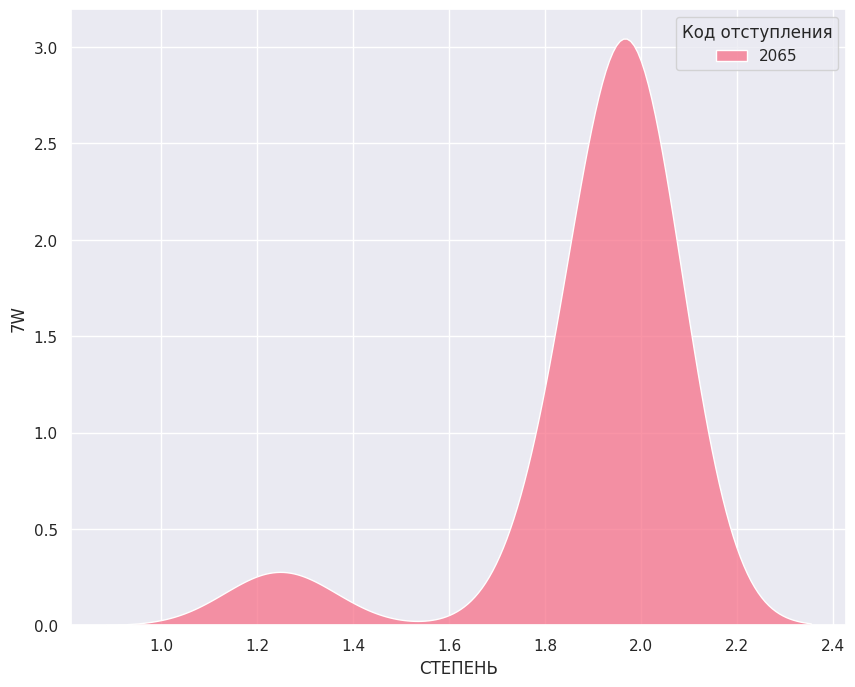

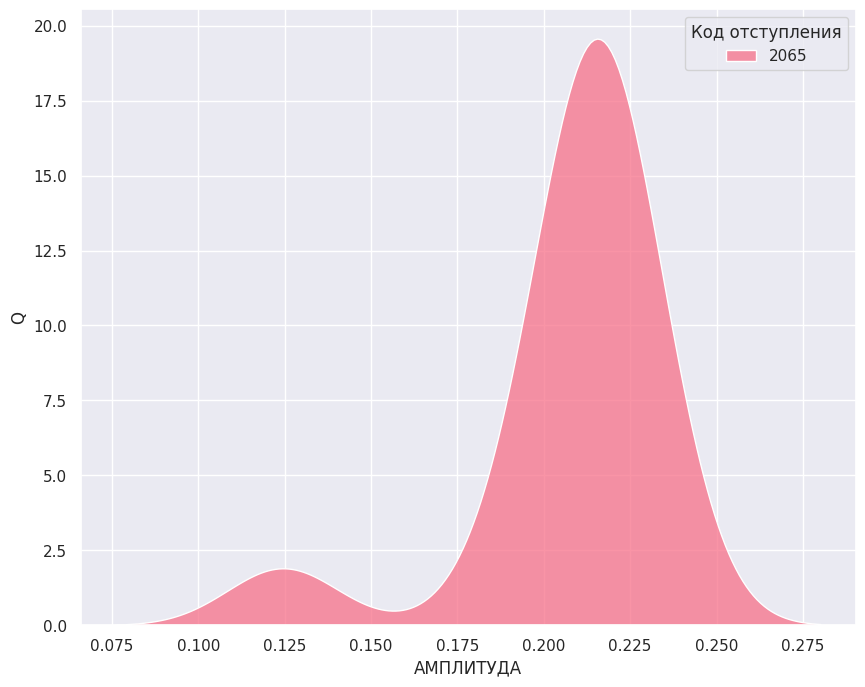

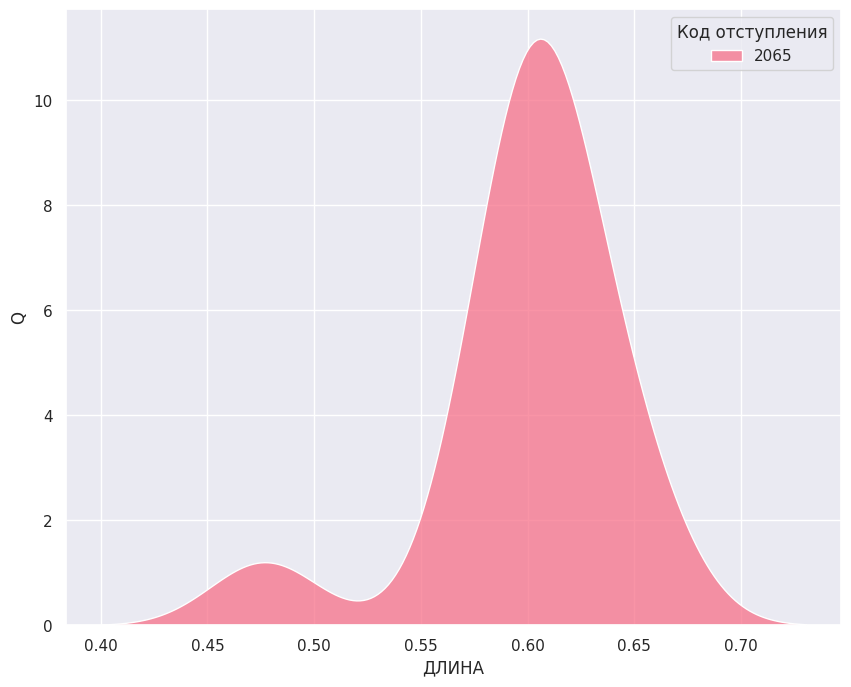

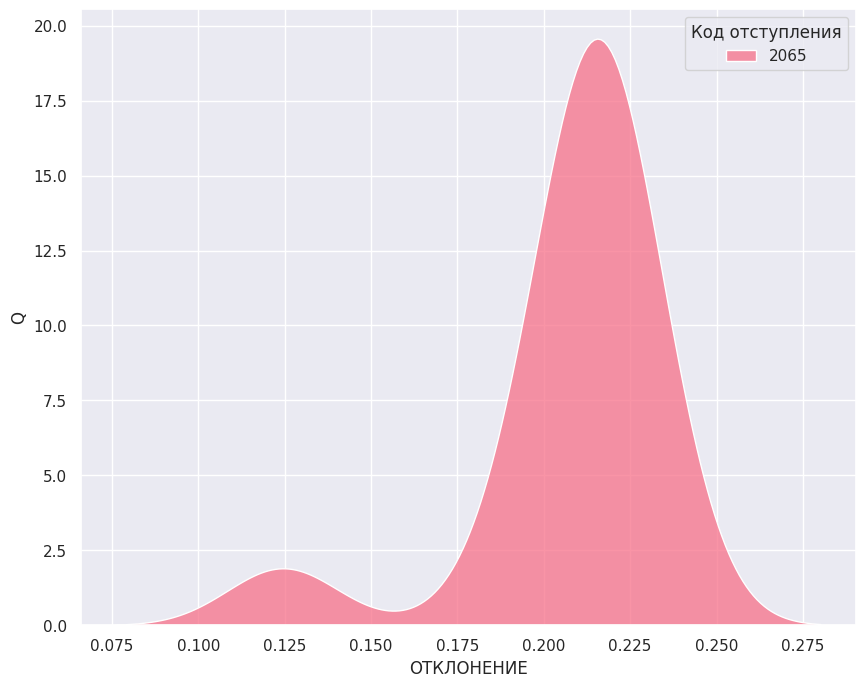

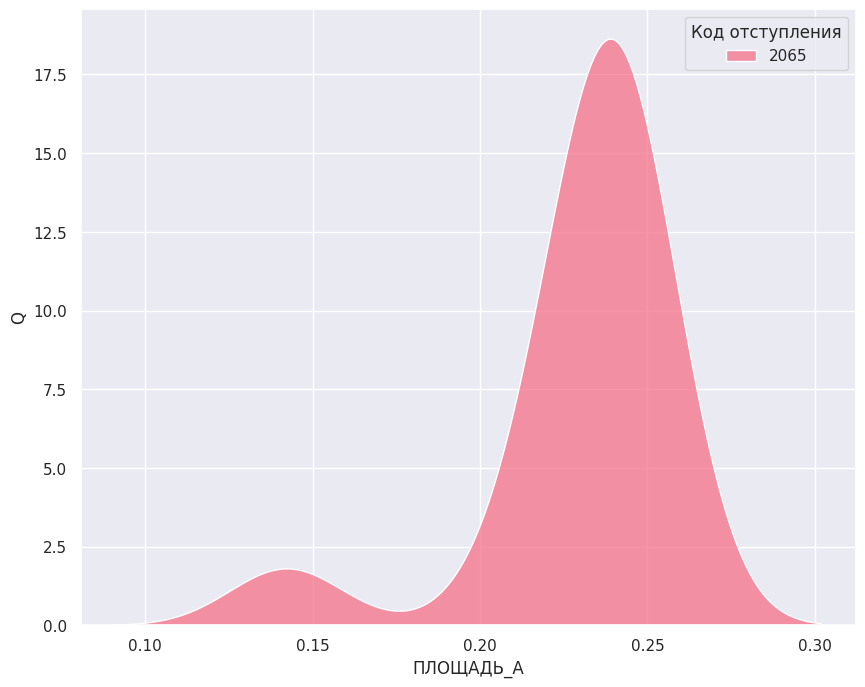

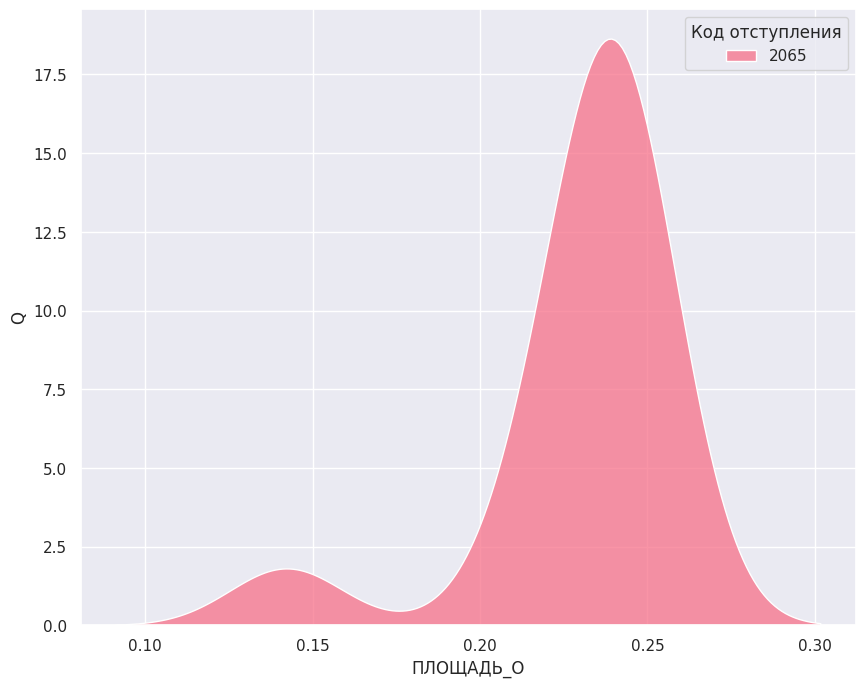

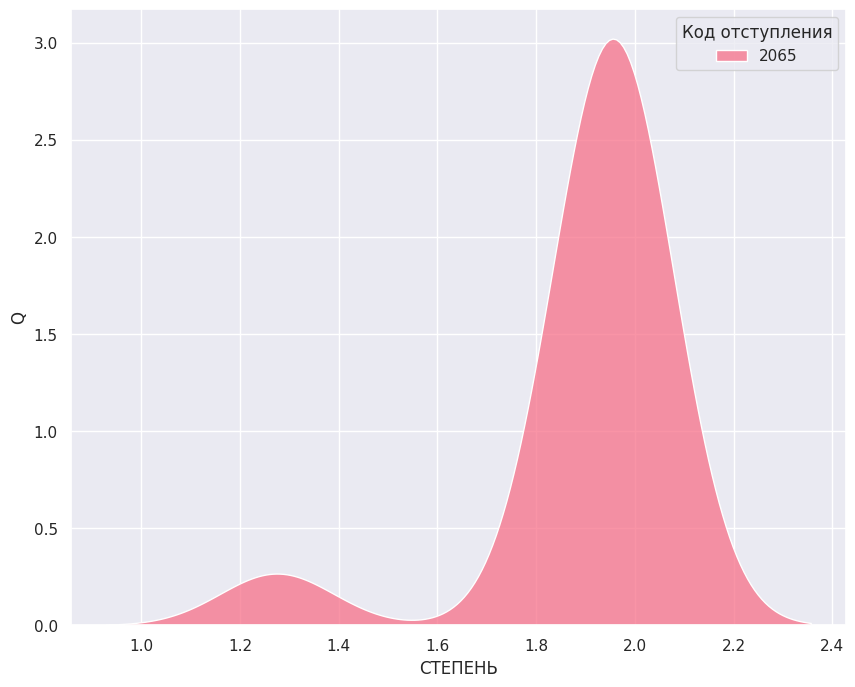

In [34]:
discr=['5W','M','2M', '3W','6W', '7W','Q']
cols=['АМПЛИТУДА', 'ДЛИНА', 'ОТКЛОНЕНИЕ','ПЛОЩАДЬ_А', 'ПЛОЩАДЬ_О','СТЕПЕНЬ']
dp=miss.reset_index()
dp.set_index('ВРЕМЯ', inplace=True)
for freq in discr:
 for col in cols:
    dps=dp.resample(freq).agg({col: 'mean', 'КМ':'last','КОДОТСТУП':'last'}).fillna(method="ffill")
    har=sns.kdeplot(data=dps, 
            x=col, multiple="stack", palette='husl', hue='КОДОТСТУП', legend=True, warn_singular=False)
    sns.move_legend(har, title='Код отступления', loc='best')  
# Setting the X and Y Label
    plt.xlabel(col)
    plt.ylabel(freq)
    plt.show()

## Временные ряды

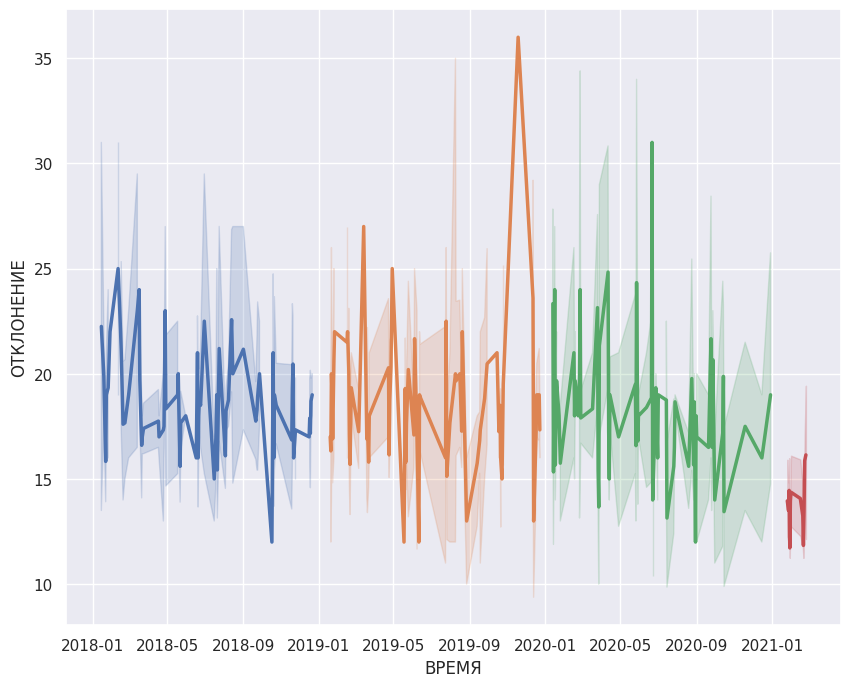

In [35]:
grouped=df.groupby(['ГОД'])
for name, group in grouped:
    if (np.sum(group.count())>10):
      sns.lineplot(data=group, x=group['ВРЕМЯ'], y=group['ОТКЛОНЕНИЕ'], linewidth=2.5)
plt.show()

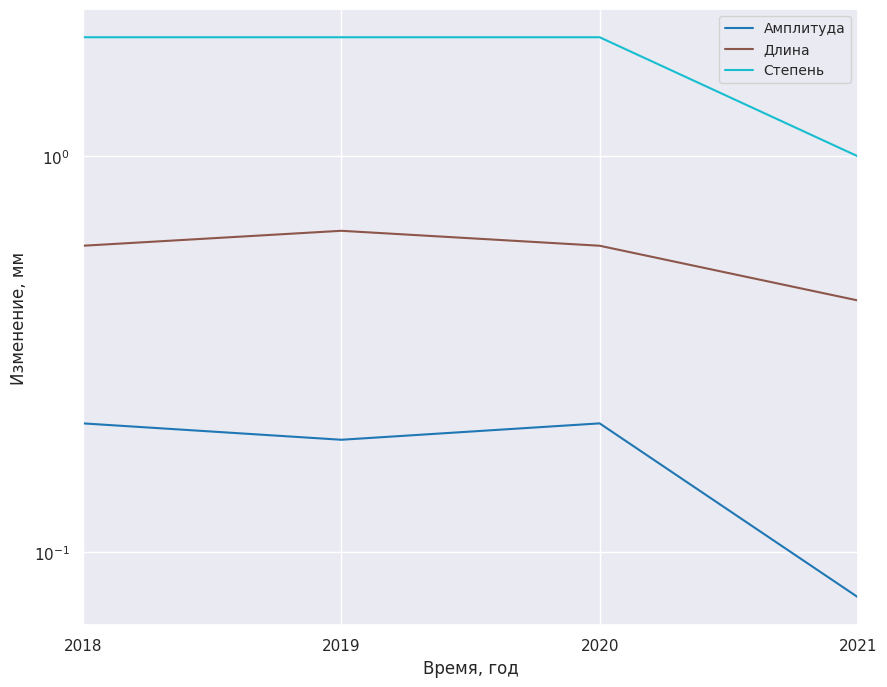

In [36]:
dp[['АМПЛИТУДА','ДЛИНА','СТЕПЕНЬ']].resample('Y', origin='start').median().plot(cmap='tab10').legend(loc='best',ncol=1,labels=['Амплитуда','Длина','Степень'],fontsize='small') 
plt.yscale('log')
plt.ylabel("Изменение, мм")
plt.xlabel("Время, год")
plt.grid(True)
plt.show()

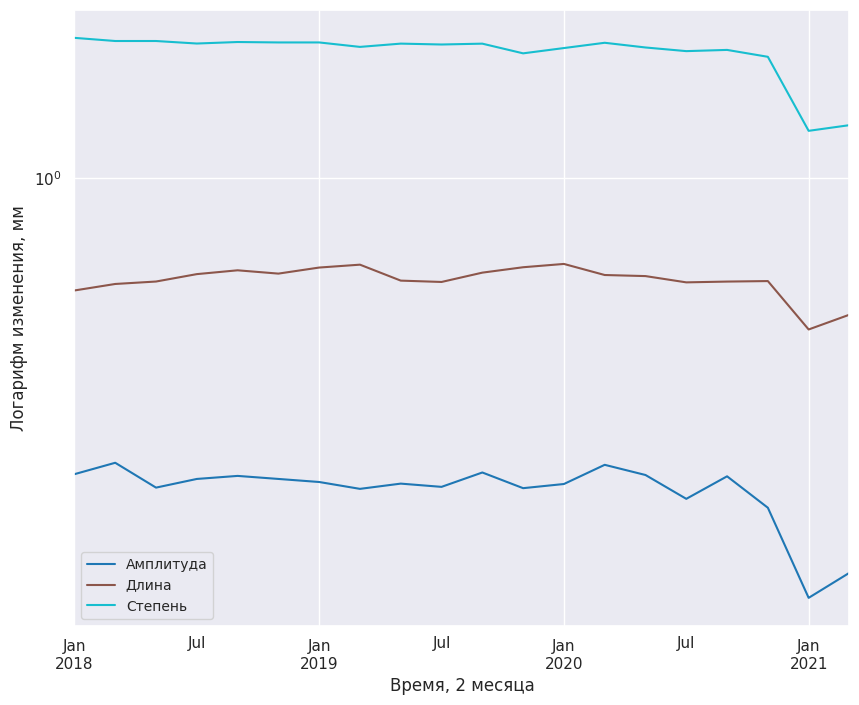

In [37]:
dp[['АМПЛИТУДА','ДЛИНА','СТЕПЕНЬ']].resample('2M', origin='start').mean().plot(cmap='tab10').legend(loc='best',ncol=1,labels=['Амплитуда','Длина','Степень'],fontsize='small') 
plt.xlabel("Время, 2 месяца")
plt.grid(True)
plt.ylabel("Логарифм изменения, мм")
plt.yscale('log')

## Статистики

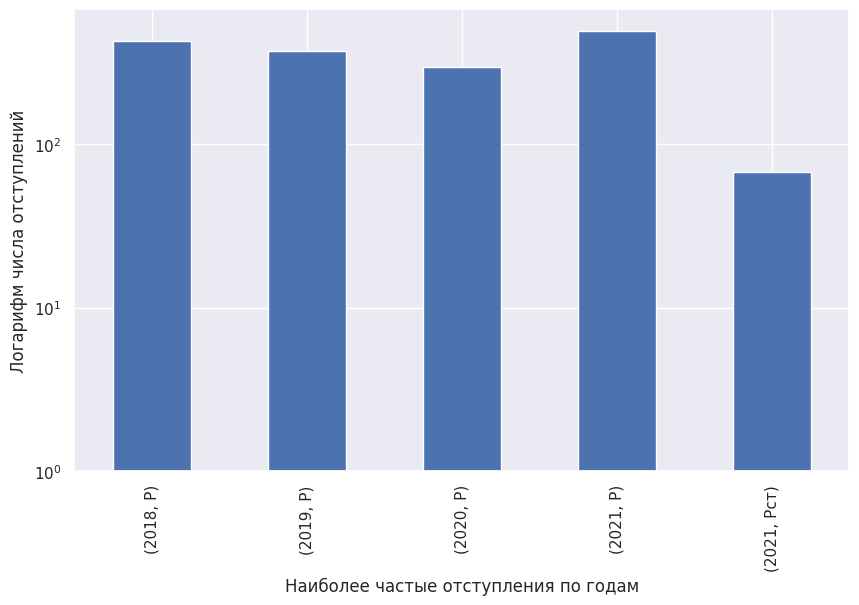

In [38]:
df.groupby('ГОД')['ОТСТУПЛЕНИЕ'].value_counts().plot.bar(figsize=(10,6), log=True)
plt.xlabel("Наиболее частые отступления по годам")
plt.ylabel("Логарифм числа отступлений")
plt.show()

<Axes: xlabel='ГОД,СТЕПЕНЬ'>

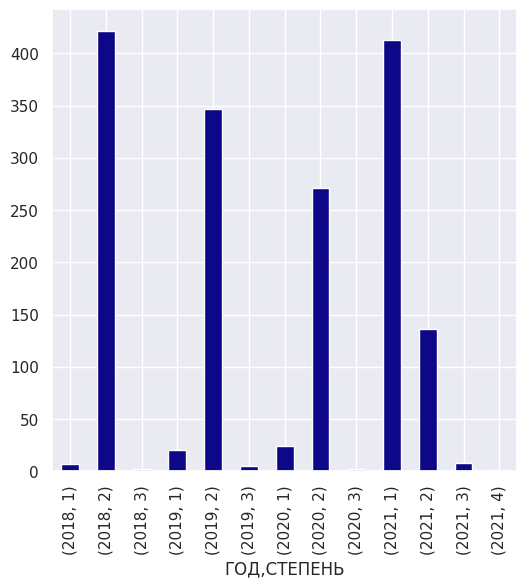

In [39]:
grouped=df.groupby(['ГОД', 'СТЕПЕНЬ']).size() 
grouped.plot.bar(figsize=(6,6), cmap='plasma') 

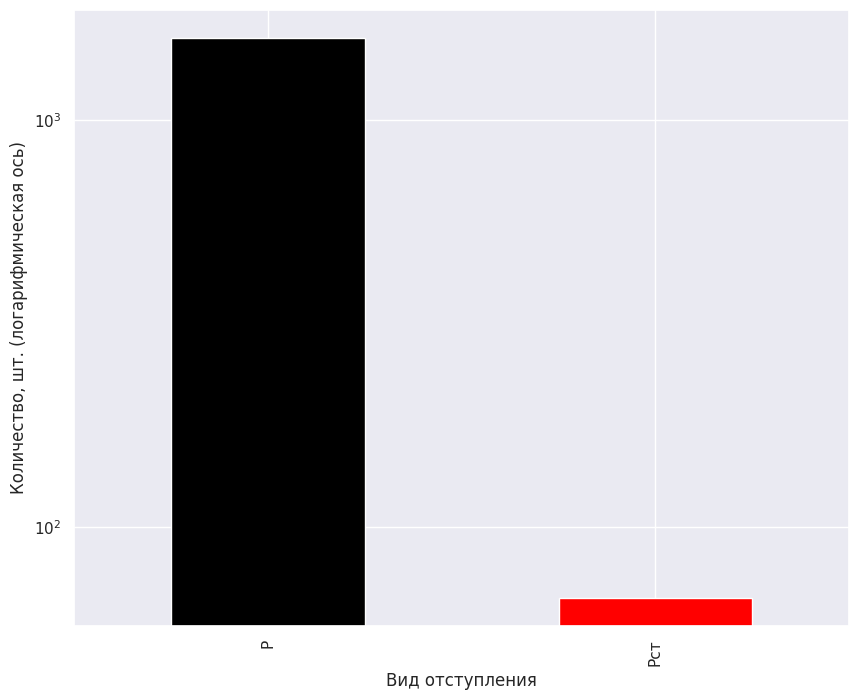

In [40]:
df.ОТСТУПЛЕНИЕ.value_counts().plot.bar(color=['black', 'red', 'green', 'blue', 'cyan','yellow', 'magenta','grey','orange'])
plt.yscale('log') 
plt.xlabel("Вид отступления")
plt.ylabel("Количество, шт. (логарифмическая ось)")
plt.show()

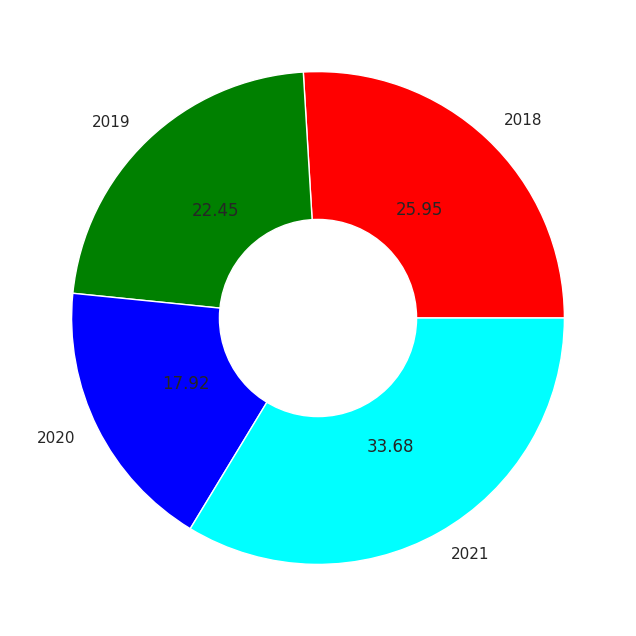

In [41]:
feature_names = "2018","2019","2020","2021"
feature_size = [len(df.loc[df['ГОД'] == 2018]),len(df.loc[df['ГОД']==2019]),len(df.loc[df['ГОД']==2020]),len(df.loc[df['ГОД']==2021])]
# create a circle for the center of plot
circle = plt.Circle((0,0),0.4,color = "white")
plt.pie(feature_size, labels = feature_names, colors = ["red","green","blue","cyan"],  autopct='%.2f' )
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

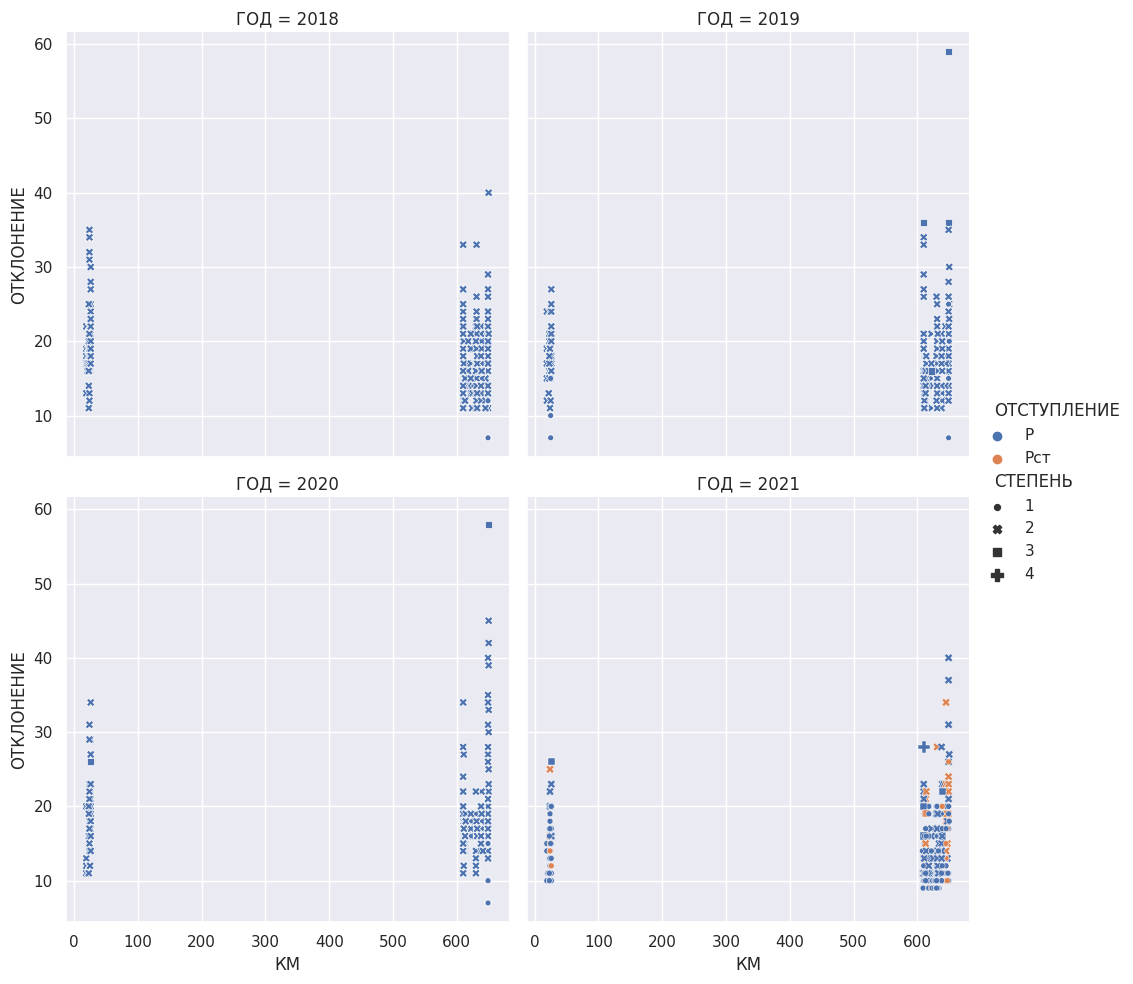

In [42]:
sns.set( rc = {'figure.figsize' : ( 10, 10 ), 
               'axes.labelsize' : 12 })
sns.relplot(data=df, x='КМ', y='ОТКЛОНЕНИЕ', col='ГОД', hue='ОТСТУПЛЕНИЕ', size='СТЕПЕНЬ', style='СТЕПЕНЬ',  kind='scatter', col_wrap=2)
plt.show()

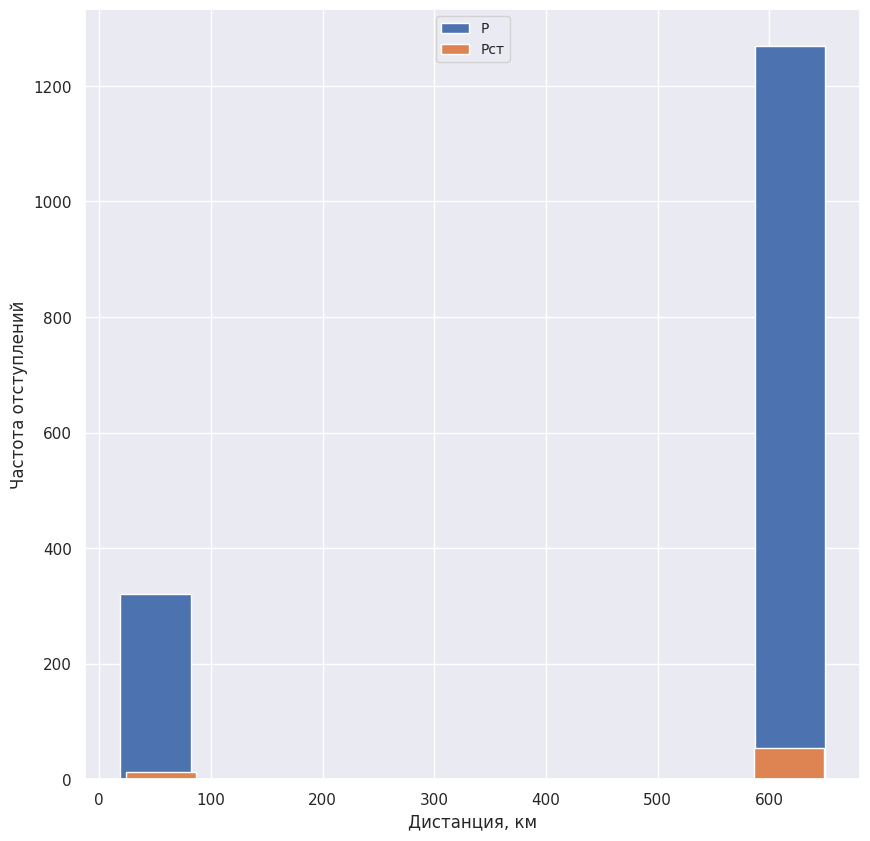

In [43]:
df.groupby('ОТСТУПЛЕНИЕ')['КМ'].hist(stacked=True, legend=True) 
plt.rcParams["figure.figsize"]=(10, 8)
plt.legend(loc='upper center', fontsize='small')
plt.xlabel("Дистанция, км")
plt.ylabel("Частота отступлений")
plt.show()

# Прогноз

In [44]:
dq=miss.reset_index().iloc[: , [0, 2, 3, 4, 6, 7, 8, 9,10, 11, 12]].copy()
dq.set_index('ВРЕМЯ', inplace=True)

In [45]:
logging.basicConfig(level=logging.ERROR)
#logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
#logging.getLogger().setLevel(logging.WARNING)
#logging.getLogger('prophet').setLevel(logging.WARNING)
#logging.getLogger('prophet.forecaster').setLevel(logging.WARNING)
discr=['6W'] #,'7W', '3W','M','D']
days_dict = {'D': 1, 'W': 7, 'M': 30, 'Q': 90, 'Y': 365}
cols=['ОТКЛОНЕНИЕ'] #,'АМПЛИТУДА', 'ПЛОЩАДЬ_А','ДЛИНА',  'ПЛОЩАДЬ_О','СТЕПЕНЬ']
#initialize predictions dataframe
predictions = pd.DataFrame(columns=['Km', 'Code', 'Column', 'Period', 'mae', 'mape', 'mse'])
for freq in discr:
 freq_coef = freq[:-1]
 freq_letter = freq[-1]
 if freq_letter not in days_dict.keys():
        raise ValueError("Invalid frequency: {}".format(freq))
 for col in cols:
  ops = dq.resample(freq_letter).agg({col: 'mean', 'КМ': 'last', 'КОДОТСТУП': 'last'}).fillna(method='bfill')
  ops['ds'] = ops.index
  ops['y']=ops[col]
  new=ops.groupby(['КМ','КОДОТСТУП'])
  forecast=[]
  for name, group in new: 
   period_days = int(round(365/days_dict[freq_letter]))
   if (len(group)>10):
    for i in range( min(round(len(group)/2), 20)):
     m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, n_changepoints=i) #, mcmc_samples=2) 
   #  m.add_seasonality(name='monthly', period=10, fourier_order=2) 
   #  m.add_seasonality(name='quarterly', period=45, fourier_order=2)
     m.fit(group)
     future = m.make_future_dataframe(periods=days_dict[freq_letter] ,freq=freq)  
     forecast = m.predict(future)
     cv_results = cross_validation(m, horizon='1W')    #freq_letter)  #   period_days)  
     df_p = performance_metrics(cv_results)
     predictions.loc[:, 'Km'] = name[0]
     predictions.loc[:, 'Code'] = name[1]
     predictions.loc[:, 'Column'] = col
     predictions.loc[:,'Period']=freq
     predictions=pd.concat([predictions, df_p[['mae', 'mape', 'mse']]])
     if (df_p['mae'] <= 0.15).any():
      print('\x1b[0;31;47m' + str(name) + freq + str(df_p['mae'])) 
  #    plt.rc('figure', max_open_warning = 0)
  #    fig=m.plot(forecast, xlabel='ВРЕМЯ, '+str(freq)+ ' точек изменения '+str(i), ylabel =str(col)+" для Км, КОДОТСТУП: "+str(name), figsize=(8, 4))
  #    m.plot_components(forecast)
  #    plt.xlabel('Время, '+str(freq)+ ' для '+str(col))
  #    plt.show()
  #    plt.close()
sorted_predictions = predictions.sort_values(by=['mae', 'mape', 'mse'], ascending=[True, True, True]) 
sorted_predictions

  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024736
1    0.045824
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024712
1    0.045827
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024703
1    0.045827
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024697
1    0.045825
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024703
1    0.045803
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024706
1    0.045812
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024689
1    0.045817
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024703
1    0.045830
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024730
1    0.045847
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024695
1    0.045820
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024686
1    0.045822
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024701
1    0.045823
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024699
1    0.045816
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024724
1    0.045834
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024707
1    0.045822
Name: mae, dtype: float64


  0%|          | 0/49 [00:00<?, ?it/s]

(24.0, 2065.0)6W0    0.024746
1    0.045844
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053705
1    0.047640
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053734
1    0.047668
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053681
1    0.047641
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053715
1    0.047654
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053738
1    0.047673
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053689
1    0.047666
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053697
1    0.047664
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053713
1    0.047669
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.05372
1    0.04768
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053686
1    0.047635
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053689
1    0.047639
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053673
1    0.047650
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053683
1    0.047671
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053660
1    0.047629
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053696
1    0.047656
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053664
1    0.047634
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053659
1    0.047647
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053656
1    0.047616
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053680
1    0.047657
Name: mae, dtype: float64


  0%|          | 0/78 [00:00<?, ?it/s]

(26.0, 2065.0)6W0    0.053663
1    0.047638
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.019868
1    0.024435
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.020204
1    0.024437
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.020197
1    0.024119
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.017795
1    0.022939
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.017786
1    0.022949
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.017322
1    0.022708
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.017772
1    0.022919
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.017305
1    0.022724
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.01730
1    0.02269
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.017302
1    0.022681
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.017309
1    0.022673
Name: mae, dtype: float64


  0%|          | 0/33 [00:00<?, ?it/s]

(649.0, 2065.0)6W0    0.017300
1    0.022682
Name: mae, dtype: float64


,Km,Code,Column,Period,mae,mape,mse
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.017300,0.090184,0.000478
0,NaN,NaN,NaN,NaN,0.017300,0.090184,0.000478
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.017302,0.090193,0.000478
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.017305,0.090209,0.000478
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.017309,0.090236,0.000479
...,...,...,...,...,...,...,...
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.053713,0.296326,0.022573
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.053715,0.296321,0.022572
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.053720,0.296341,0.022573
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.053734,0.296421,0.022573


In [46]:
sorted_predictions

,Km,Code,Column,Period,mae,mape,mse
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.017300,0.090184,0.000478
0,NaN,NaN,NaN,NaN,0.017300,0.090184,0.000478
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.017302,0.090193,0.000478
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.017305,0.090209,0.000478
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.017309,0.090236,0.000479
...,...,...,...,...,...,...,...
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.053713,0.296326,0.022573
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.053715,0.296321,0.022572
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.053720,0.296341,0.022573
0,649.0,2065.0,ОТКЛОНЕНИЕ,6W,0.053734,0.296421,0.022573
